In [1]:
#lets import the required libraries.
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import datetime
import holidays
from datetime import date

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor


import numpy as np   
import pandas as pd   
import matplotlib.pyplot as plt   
from matplotlib import pyplot
import seaborn as sns   
import warnings
warnings.filterwarnings('ignore')   




In [2]:
#Computing Performance Metrics
def WMAE(dataset, real, predicted):
  
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)





#here we are plotting features in decreasing order of theit importace while finding Sales using machine learning models
def plot_features_importance(importance, names, model_type):
    """
    This function plots the model features importance 
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)


    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10, 7))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()





#here we are creating Markdown features copies to find the Nan values later
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df


# In[ ]:



#This function is creating eta square test
def correlation_ratio(categories, measurements):
        fcat, _ = pd.factorize(categories)
        cat_num = np.max(fcat)+1
        y_avg_array = np.zeros(cat_num)
        n_array = np.zeros(cat_num)
        for i in range(0,cat_num):
            cat_measures = measurements[np.argwhere(fcat == i).flatten()]
            n_array[i] = len(cat_measures)
            y_avg_array[i] = np.average(cat_measures)
        y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
        numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
        denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
        if numerator == 0:
            eta = 0.0
        else:
            eta = numerator/denominator
        return eta


# In[ ]:


#this funtion will be training datset using Random forest Model
def random_forest(n_estimators, max_depth):
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                X_train, X_test, y_train, y_test = train_test_split(data, train['Weekly_Sales'], test_size=0.2)
                RF.fit(X_train, y_train)
                predicted = RF.predict(X_test)
                wmaes_cv.append(WMAE(X_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))


# In[ ]:


#this funtion will be training datset using GBDT Model
def gbdt(n_estimators, max_depth):
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                RF = lgb.LGBMRegressor(n_estimators=estimator, max_depth=depth)
                X_train, X_test, y_train, y_test = train_test_split(data, train['Weekly_Sales'], test_size=0.2)
                
                RF.fit(X_train, y_train)
                predicted = RF.predict(X_test)
                wmaes_cv.append(WMAE(X_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))


# In[ ]:


#this funtion will be training datset using Elastic Net(Linear Regression) Model

def linear_regression(l1_ratio):
    for l1 in l1_ratio:
        wmaes_cv = []
        for i in range(1, 5):
            print('k:', i, ', l1_ratio:', l1)
            # 'normalize' parameter removed
            lr = ElasticNet(random_state=0, l1_ratio=l1)
            X_train, X_test, y_train, y_test = train_test_split(
                data, train['Weekly_Sales'], test_size=0.2)
            t = MinMaxScaler()
            t.fit(X_train)
            train_data = t.transform(X_train)
            test_data = t.transform(X_test)
            lr.fit(train_data, y_train)
            predicted = lr.predict(test_data)
            wmaes_cv.append(WMAE(X_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))




In [3]:
#reading data

train = pd.read_csv("../data/train.csv")
train.head

<bound method NDFrame.head of         Store  Dept        Date  Weekly_Sales  IsHoliday
0           1     1  2010-02-05      24924.50      False
1           1     1  2010-02-12      46039.49       True
2           1     1  2010-02-19      41595.55      False
3           1     1  2010-02-26      19403.54      False
4           1     1  2010-03-05      21827.90      False
...       ...   ...         ...           ...        ...
421565     45    98  2012-09-28        508.37      False
421566     45    98  2012-10-05        628.10      False
421567     45    98  2012-10-12       1061.02      False
421568     45    98  2012-10-19        760.01      False
421569     45    98  2012-10-26       1076.80      False

[421570 rows x 5 columns]>

In [4]:
test = pd.read_csv("../data/test.csv")


test.head

<bound method NDFrame.head of         Store  Dept        Date  IsHoliday
0           1     1  2012-11-02      False
1           1     1  2012-11-09      False
2           1     1  2012-11-16      False
3           1     1  2012-11-23       True
4           1     1  2012-11-30      False
...       ...   ...         ...        ...
115059     45    98  2013-06-28      False
115060     45    98  2013-07-05      False
115061     45    98  2013-07-12      False
115062     45    98  2013-07-19      False
115063     45    98  2013-07-26      False

[115064 rows x 4 columns]>

In [5]:
stores = pd.read_csv("../data/stores.csv")
stores.head

<bound method NDFrame.head of     Store Type    Size
0       1    A  151315
1       2    A  202307
2       3    B   37392
3       4    A  205863
4       5    B   34875
5       6    A  202505
6       7    B   70713
7       8    A  155078
8       9    B  125833
9      10    B  126512
10     11    A  207499
11     12    B  112238
12     13    A  219622
13     14    A  200898
14     15    B  123737
15     16    B   57197
16     17    B   93188
17     18    B  120653
18     19    A  203819
19     20    A  203742
20     21    B  140167
21     22    B  119557
22     23    B  114533
23     24    A  203819
24     25    B  128107
25     26    A  152513
26     27    A  204184
27     28    A  206302
28     29    B   93638
29     30    C   42988
30     31    A  203750
31     32    A  203007
32     33    A   39690
33     34    A  158114
34     35    B  103681
35     36    A   39910
36     37    C   39910
37     38    C   39690
38     39    A  184109
39     40    A  155083
40     41    A  196321
41  

In [67]:
features = pd.read_csv("../data/features.csv")
features.head

<bound method NDFrame.head of       Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0         1  2010-02-05        42.31       2.572        NaN        NaN   
1         1  2010-02-12        38.51       2.548        NaN        NaN   
2         1  2010-02-19        39.93       2.514        NaN        NaN   
3         1  2010-02-26        46.63       2.561        NaN        NaN   
4         1  2010-03-05        46.50       2.625        NaN        NaN   
...     ...         ...          ...         ...        ...        ...   
8185     45  2013-06-28        76.05       3.639    4842.29     975.03   
8186     45  2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45  2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45  2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45  2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0   

In [7]:
print("the structure of train data is ", train.shape)
print("the structure of test  data is ", test.shape)
train.dtypes

the structure of train data is  (421570, 5)
the structure of test  data is  (115064, 4)


Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [8]:
train.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:

test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [68]:
#lets convert date column into datetime type

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)
features.Date = pd.to_datetime(features.Date)

In [11]:
train.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

In [12]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.isocalendar().week
train['Day'] = train['Date'].dt.day
train['n_days'] = (train['Date'].dt.date -
                   train['Date'].dt.date.min()).apply(lambda x: x.days)
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Week,Day,n_days
0,1,1,2010-02-05,24924.50,False,2010,2,5,5,0
1,1,1,2010-02-12,46039.49,True,2010,2,6,12,7
2,1,1,2010-02-19,41595.55,False,2010,2,7,19,14
3,1,1,2010-02-26,19403.54,False,2010,2,8,26,21
4,1,1,2010-03-05,21827.90,False,2010,3,9,5,28


In [13]:
print("Holiday")
print(train[train['IsHoliday'] == True]['Weekly_Sales'].describe())
print("Non-Holiday")
print(train[train['IsHoliday'] == False]['Weekly_Sales'].describe())

Holiday
count     29661.000000
mean      17035.823187
std       27222.000409
min        -798.000000
25%        2078.540000
50%        7947.740000
75%       21189.250000
max      693099.360000
Name: Weekly_Sales, dtype: float64
Non-Holiday
count    391909.000000
mean      15901.445069
std       22330.747450
min       -4988.940000
25%        2079.750000
50%        7589.950000
75%       20131.210000
max      406988.630000
Name: Weekly_Sales, dtype: float64


 !! sales in holiday week are more than sales in non-holiday week
 and now check if there is any trend in the year 


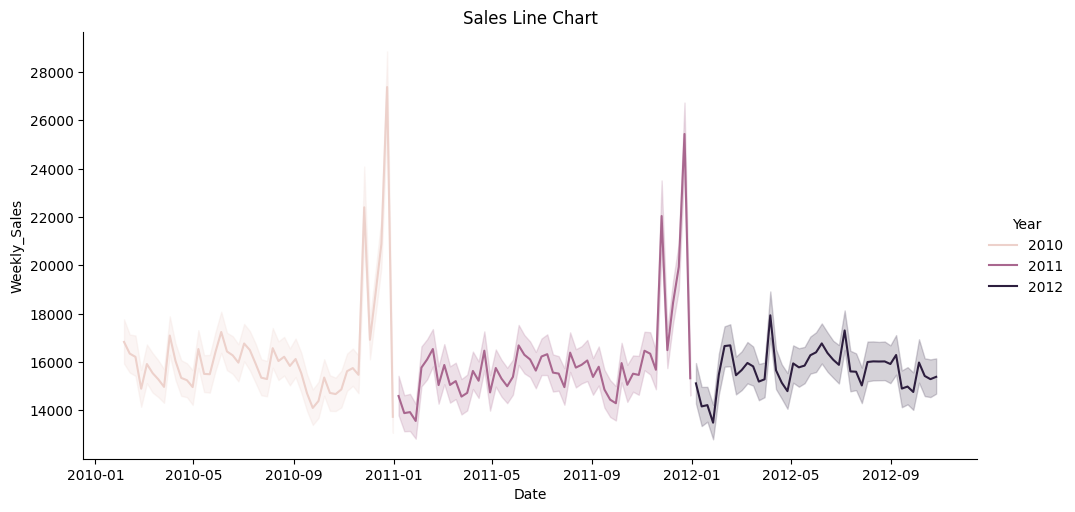

In [14]:
sns.relplot(x='Date', y='Weekly_Sales', hue='Year',
            data=train, kind='line', aspect=2)
plt.title("Sales Line Chart")
#plt.savefig("line_chart_time_series.png")
plt.show()


 It can be seen through Line chart that there is no trend in year wise and no random event also happen in any year.
 
 Also it can be seen that at the end of the year there is hufe sales compared to other month whih tells that christmas and thanksgiving has more impact on sales compared to Super Bowl ,Labour Day.
 

 So We can create features where we can give seperate category for each holiday.

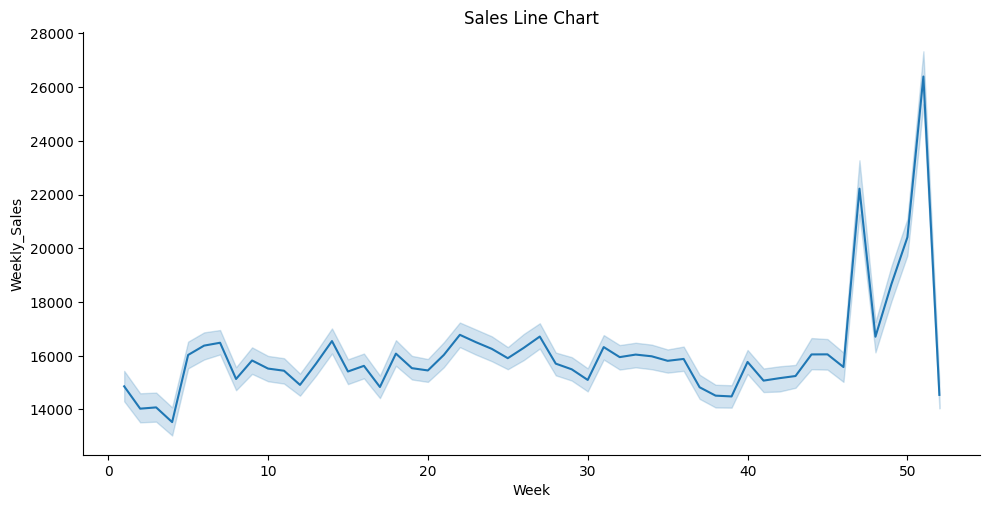

In [15]:
sns.relplot(x='Week', y='Weekly_Sales', data=train, kind='line', aspect=2)
plt.title("Sales Line Chart")
#plt.savefig("week_Sales_Line_Chart.png")

plt.show()

week 45 to 50 have higher sales where Christmas and thanksgiving comes.


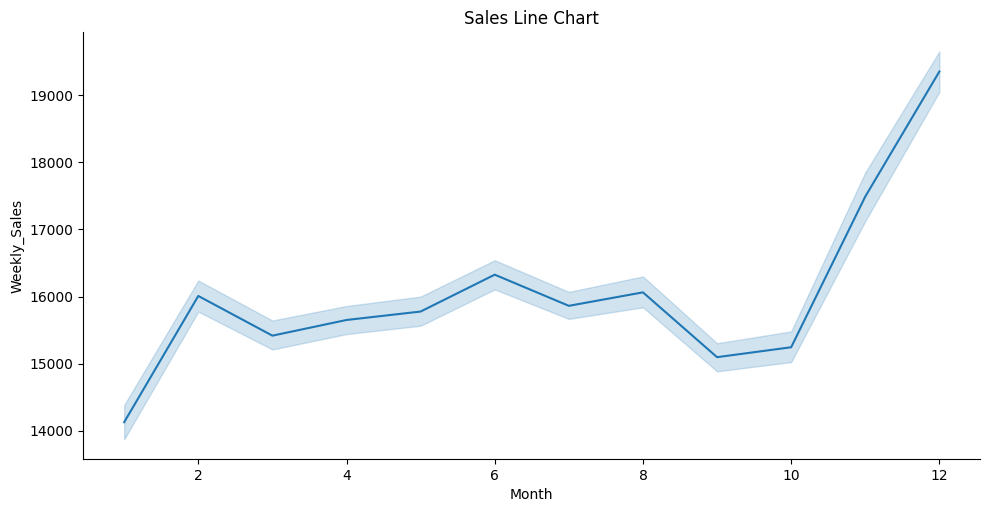

In [16]:
sns.relplot(x='Month', y='Weekly_Sales', data=train, kind='line', aspect=2)
plt.title("Sales Line Chart")
#plt.savefig("month_Sales_Line_Chart.png")


plt.show()

november and december sales are very high compared to other month wich tells the impact of thanksgiving and christmas on sales.


In [17]:

#Merge train with features and stores dataframes
train = pd.merge(train, features, on=[
                 'Store', 'Date', 'IsHoliday'], how='left')
train = pd.merge(train, stores, on=['Store'], how='left')

#Display the first few rows of the merged dataframe
train.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Week,Day,n_days,...,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,2010,2,5,5,0,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,2010,2,6,12,7,...,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,2010,2,7,19,14,...,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,2010,2,8,26,21,...,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,2010,3,9,5,28,...,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [18]:
train.shape


(421570, 21)

check Which Features are more correlated to Weekly_Sale


In [19]:
print("Correlation of store feature with weekly_sales")
print(correlation_ratio(train['Store'], train['Weekly_Sales']))
print(50*'*')
print("Correlation of Department feature with weekly_sales")
print(correlation_ratio(train['Dept'], train['Weekly_Sales']))
print(50*'*')
print("Correlation of Type feature with weekly_sales")
print(correlation_ratio(train['Type'], train['Weekly_Sales']))
print(50*'*')

Correlation of store feature with weekly_sales
0.09320619110455744
**************************************************
Correlation of Department feature with weekly_sales
0.5368007370698533
**************************************************
Correlation of Type feature with weekly_sales
0.035527338793980845
**************************************************


Department feature is highly correlated with Weekly_Sales.


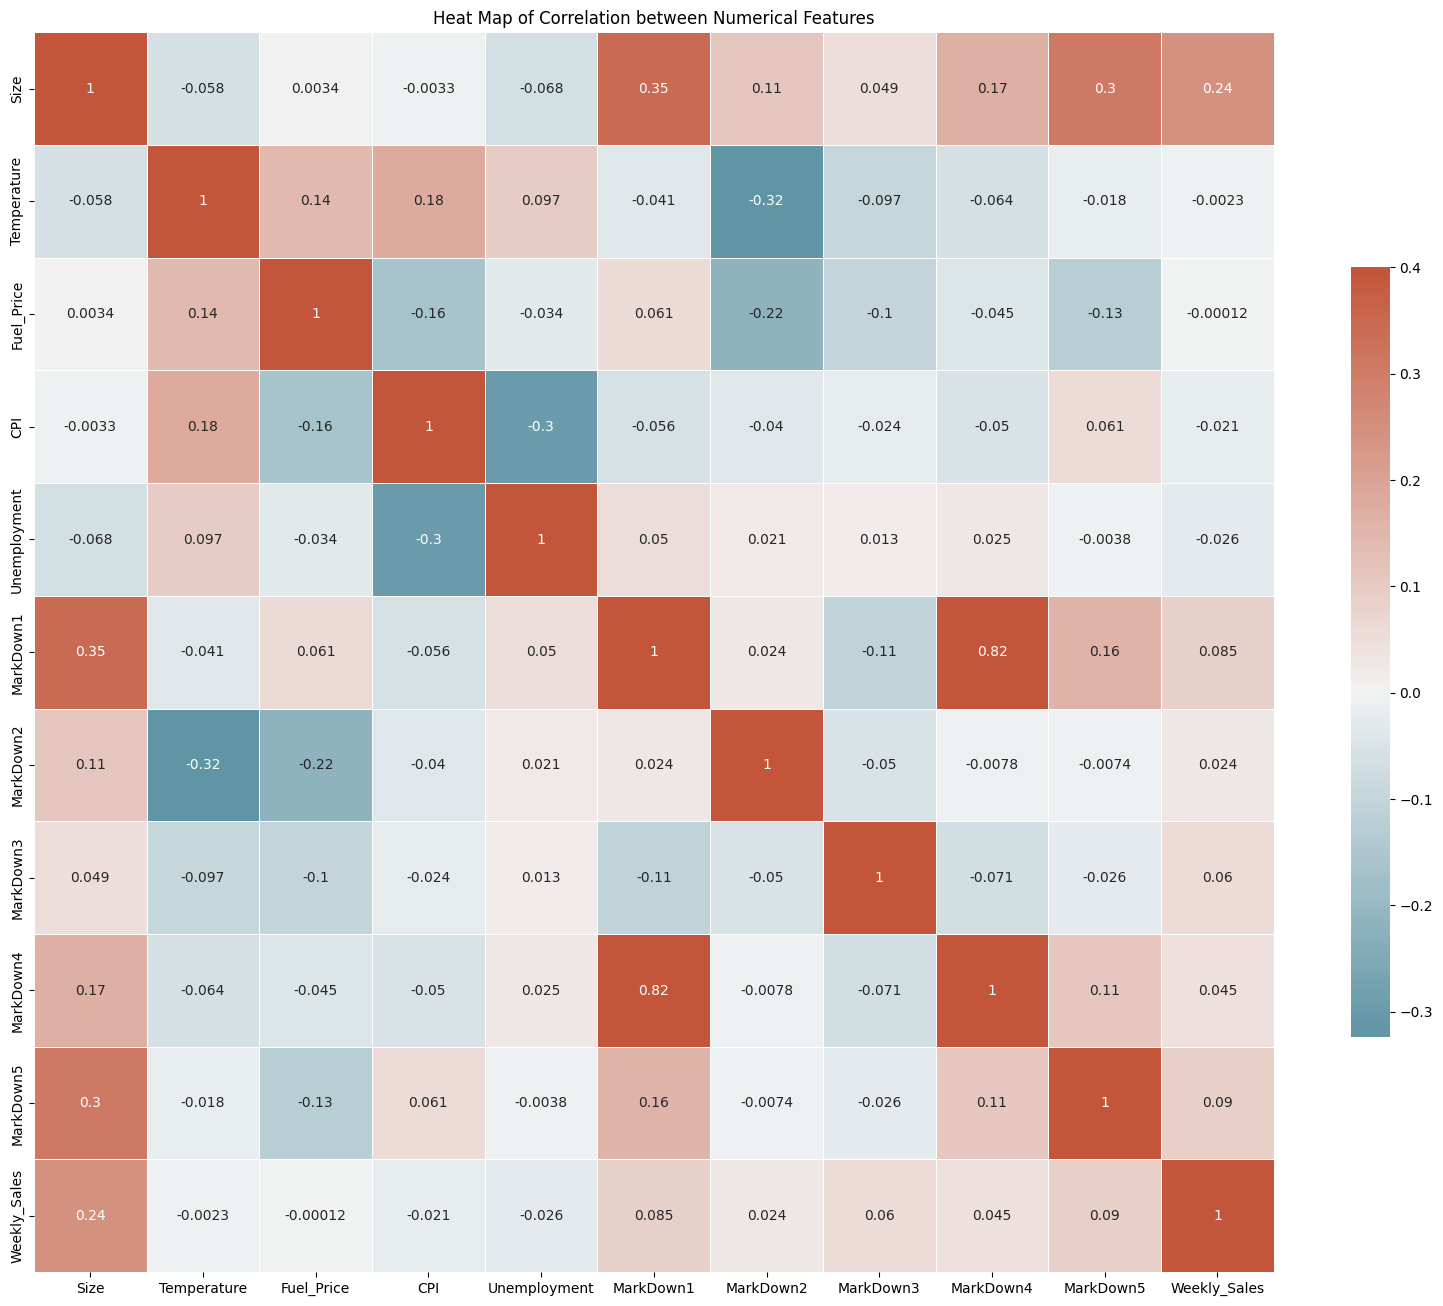

In [20]:
data = pd.concat([train['Size'], train['Temperature'], train['Fuel_Price'], train['CPI'], train['Unemployment'],
                  train['MarkDown1'], train['MarkDown2'], train['MarkDown3'], train['MarkDown4'],
                  train['MarkDown5'], train['Weekly_Sales']], axis=1)
corr = data.corr()
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.4, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.title("Heat Map of Correlation between Numerical Features")
#plt.savefig("heatmap_correlation_numerical.png")
plt.show()


 Size is most correlated with Weekly_Sales.
 

In [21]:
data = train.loc[:, train.columns != 'Weekly_Sales']
data = data.loc[:, data.columns != 'Date']
data['Type'] = data['Type'].astype('category')
data['Type'] = data['Type'].cat.codes
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
d = imp.fit_transform(pd.concat([data['MarkDown1'], data['MarkDown2'],
                                 data['MarkDown3'], data['MarkDown4'], data['MarkDown5']], axis=1))
data['MarkDown1'] = d[:, 0]
data['MarkDown2'] = d[:, 1]
data['MarkDown3'] = d[:, 2]
data['MarkDown4'] = d[:, 3]
data['MarkDown5'] = d[:, 4]

In [22]:
data.describe
train['Weekly_Sales'].describe

<bound method NDFrame.describe of 0         24924.50
1         46039.49
2         41595.55
3         19403.54
4         21827.90
            ...   
421565      508.37
421566      628.10
421567     1061.02
421568      760.01
421569     1076.80
Name: Weekly_Sales, Length: 421570, dtype: float64>

In [23]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(data, train['Weekly_Sales'])

RandomForestRegressor()

In [24]:
feature_importance_values = clf.feature_importances_
features = np.array(data.columns)
important_features = [x for _, x in sorted(
    zip(feature_importance_values, features), reverse=True)]
print("Top 5 Important Features:")
print(important_features[0:5])

Top 5 Important Features:
['Dept', 'Size', 'Store', 'Week', 'CPI']


In [25]:
#Let's look at the type of values in Stores dataset.

print("the shape of stores data set is: ", stores.shape)
print("the unique value of store is: ", stores['Store'].unique())
print("the unique value of Type is: ", stores['Type'].unique())

the shape of stores data set is:  (45, 3)
the unique value of store is:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
the unique value of Type is:  ['A' 'B' 'C']


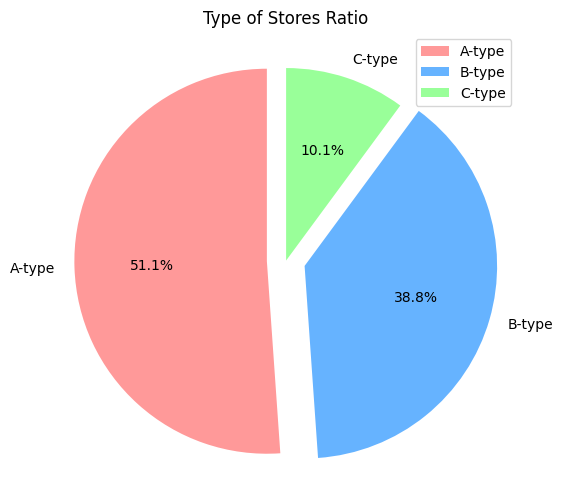

In [26]:
Count_A, Count_B, Count_C = train['Type'].value_counts()
Tasks = [Count_A, Count_B, Count_C]
couleurs = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
#Adjust the length of explode to match the length of Tasks
explode = (0.1, 0.1, 0)
plt.figure(figsize=(6, 6))

i_labels = 'A-type', 'B-type', 'C-type'
plt.pie(Tasks, labels=i_labels, autopct='%1.1f%%',
        startangle=90, colors=couleurs, explode=explode)
plt.legend()

plt.title('Type of Stores Ratio')
plt.axis('equal')

plt.show()

As it can be seen that there are many stores of A-type and very less stores of C-type

In [27]:
grouped = stores.groupby('Type')
print(grouped.describe()['Size'])

      count           mean           std      min        25%       50%  \
Type                                                                     
A      22.0  177247.727273  49392.621098  39690.0  155840.75  202406.0   
B      17.0  101190.705882  32371.137916  34875.0   93188.00  114533.0   
C       6.0   40541.666667   1304.145033  39690.0   39745.00   39910.0   

           75%       max  
Type                      
A     203819.0  219622.0  
B     123737.0  140167.0  
C      40774.0   42988.0  


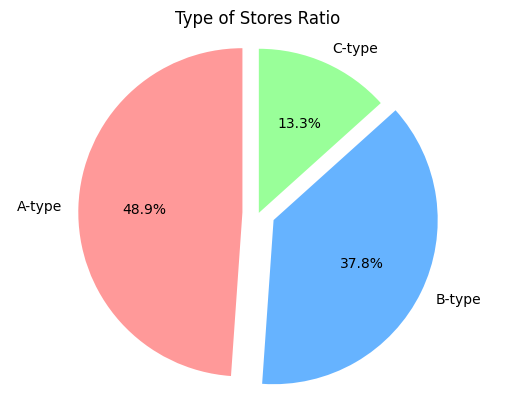

In [28]:
sizes = [(22/(17+6+22))*100, (17/(17+6+22))*100, (6/(17+6+22))*100]
i_labels = 'A-type', 'B-type', 'C-type'
couleurs = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
explode = (0.1, 0.1, 0)
plt.pie(sizes, labels=i_labels, autopct='%1.1f%%',
        startangle=90, colors=couleurs, explode=explode)

plt.title('Type of Stores Ratio')
plt.axis('equal')
plt.show()

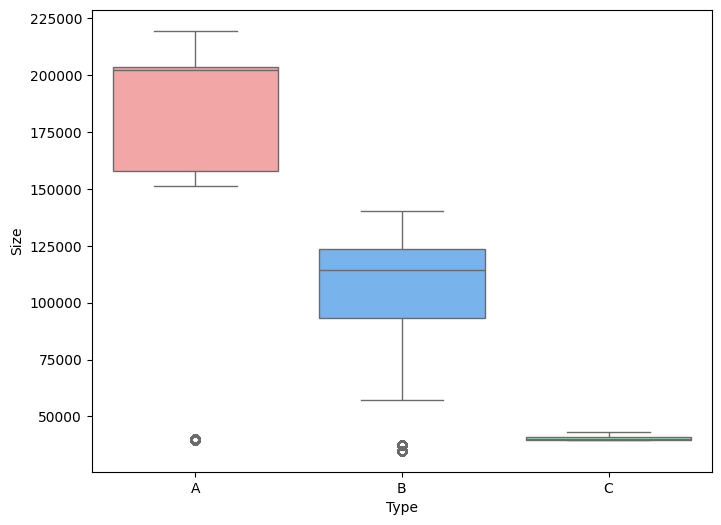

In [29]:
f, ax = plt.subplots(figsize=(8, 6))
couleurs = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
fig = sns.boxplot(x='Type', y='Size', data=train, palette=couleurs)

 Conclusion:
 Looking at the pie chart you can figure out that type is alias to the size. type A has stores of largest size ,then B and finally C.

 Looking at he box plot, it can be seen that box plot of A is not even ovelapping at any point which means that the conclusion of sizes of Stores w.r.t to type stands strong.

 Now Let's see if size has to do anything with weekly sales.

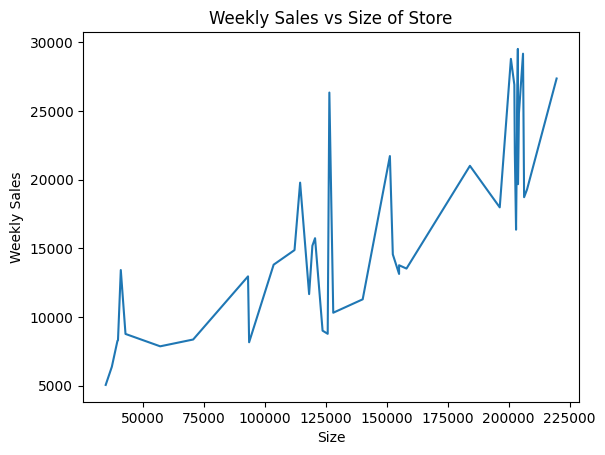

In [30]:


grouped_1 = train.groupby('Size')
train['Weekly_Sales'] = pd.to_numeric(train['Weekly_Sales'], errors='coerce')
weekly_sales = grouped_1['Weekly_Sales'].mean().reset_index()

# Sorting based on 'Size'
weekly_sales = weekly_sales.sort_values(by='Size')
size = weekly_sales['Size']
weekly_sale = weekly_sales['Weekly_Sales']

# Plotting
plt.plot(size, weekly_sale)
plt.title('Weekly Sales vs Size of Store')
plt.xlabel('Size')
plt.ylabel('Weekly Sales')
plt.show()

 through this line chart it can be seen that as size increases, weekly sales also increases.
 look the sales of storefor each type of store using box plot

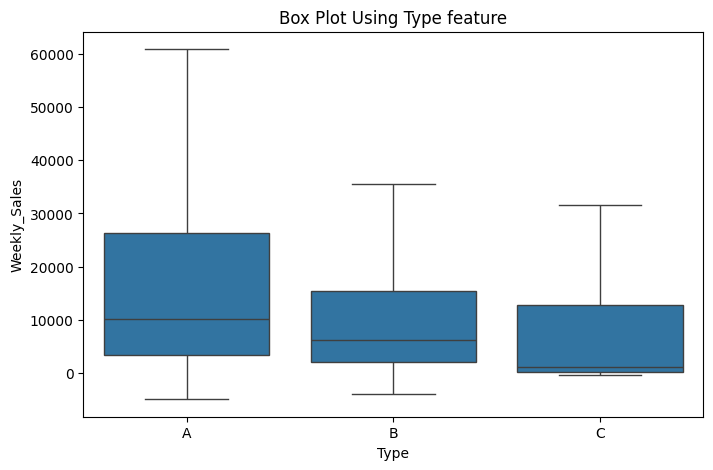

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
fig = sns.boxplot(x='Type', y='Weekly_Sales', data=train, showfliers=False)
plt.title("Box Plot Using Type feature")
plt.show()

type is an import categorical
cuz   median of each type of store decreases from left to right means from A store to C

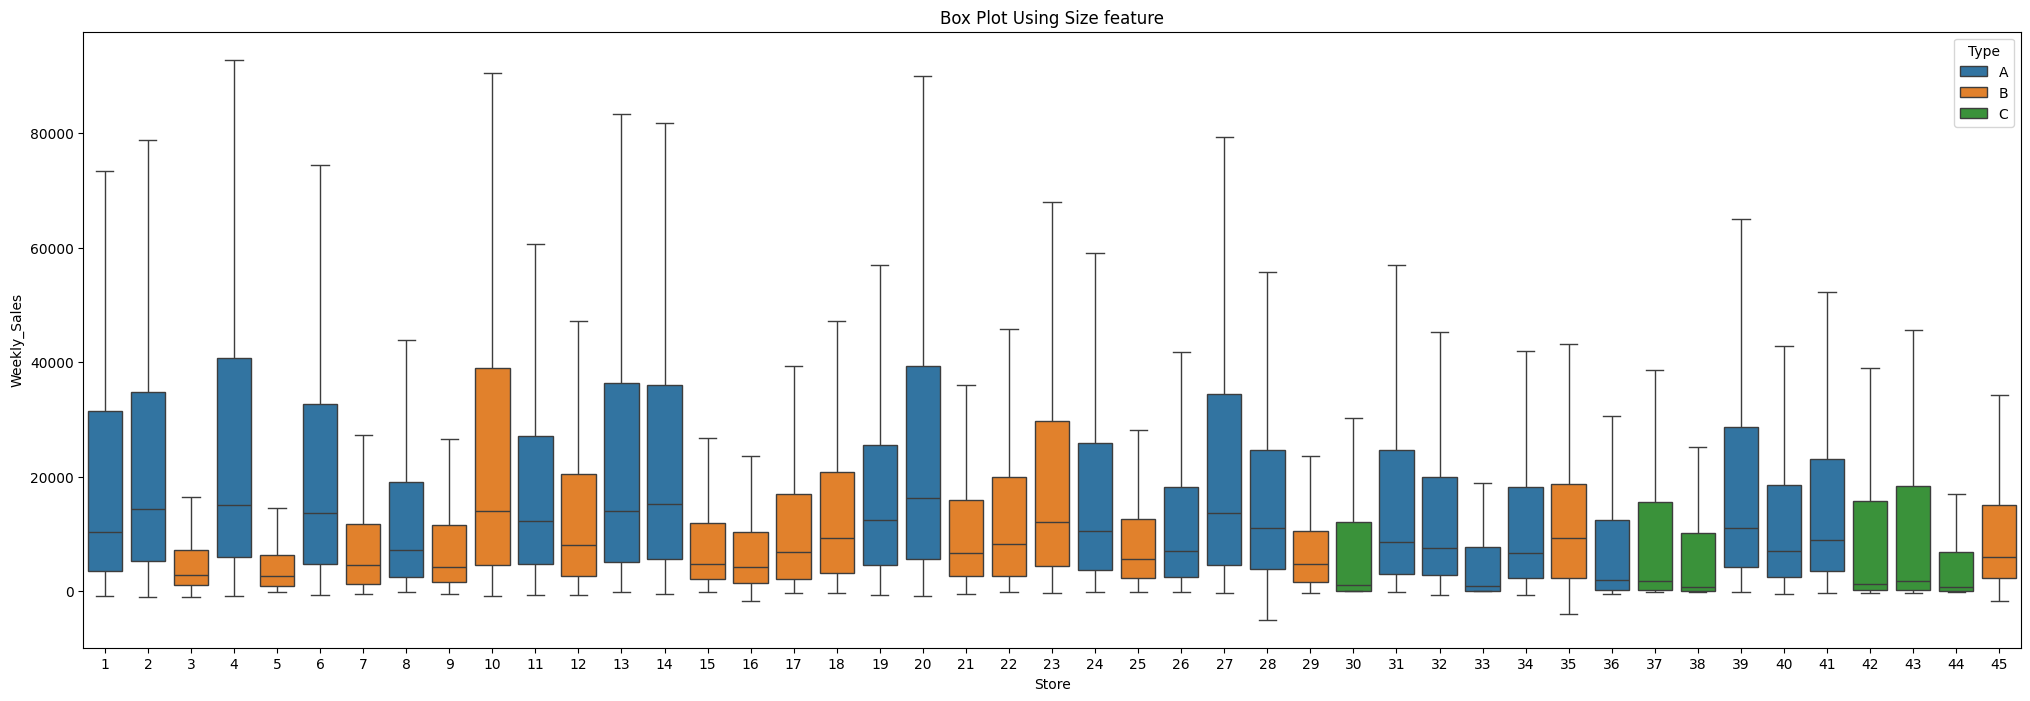

In [32]:

fig, ax = plt.subplots(figsize=(25, 8))
sns.boxplot(x="Store", y='Weekly_Sales', data=train,
            showfliers=False, hue="Type")
plt.title("Box Plot Using Size feature")
plt.show()

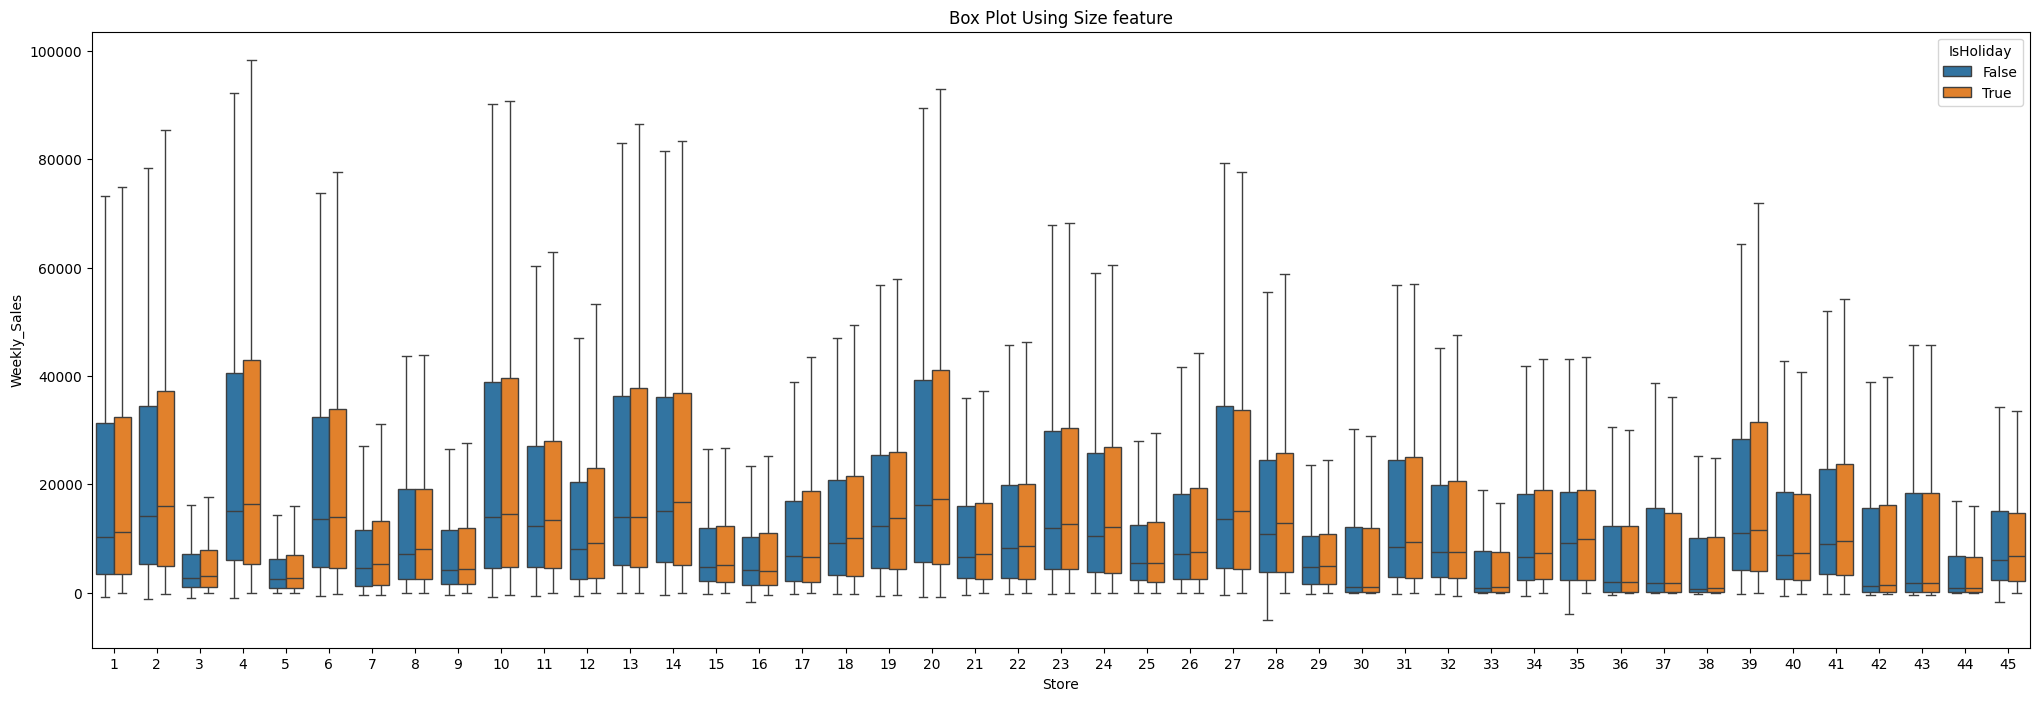

In [33]:
fig, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=train,
                  showfliers=False, hue="IsHoliday")
plt.title("Box Plot Using Size feature")
plt.show()

impact of holidays on sales of the store
sales have increased

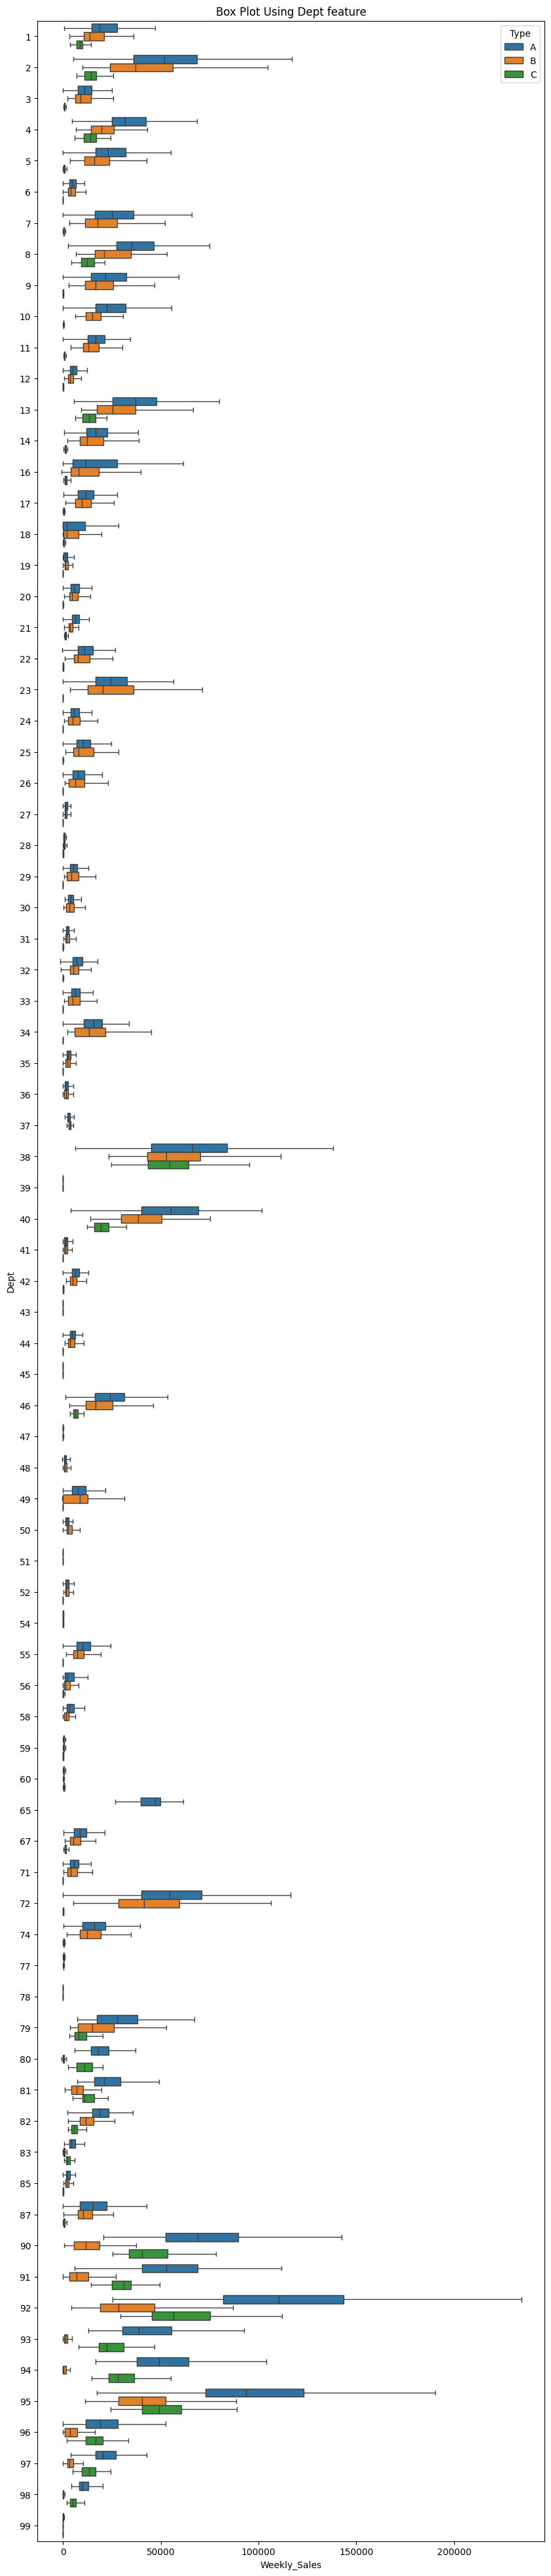

In [34]:
fig, ax = plt.subplots(figsize=(10, 50))
fig = sns.boxplot(y='Dept', x='Weekly_Sales', data=train, showfliers=False, hue="Type",orient="h") 
plt.title("Box Plot Using Dept feature")
plt.savefig("box_plot_department_feature.png")
plt.show()

impact of  Department on sales of the store
 department has a different sales than other.
 department factor is also correlated with type
 A has higher sales

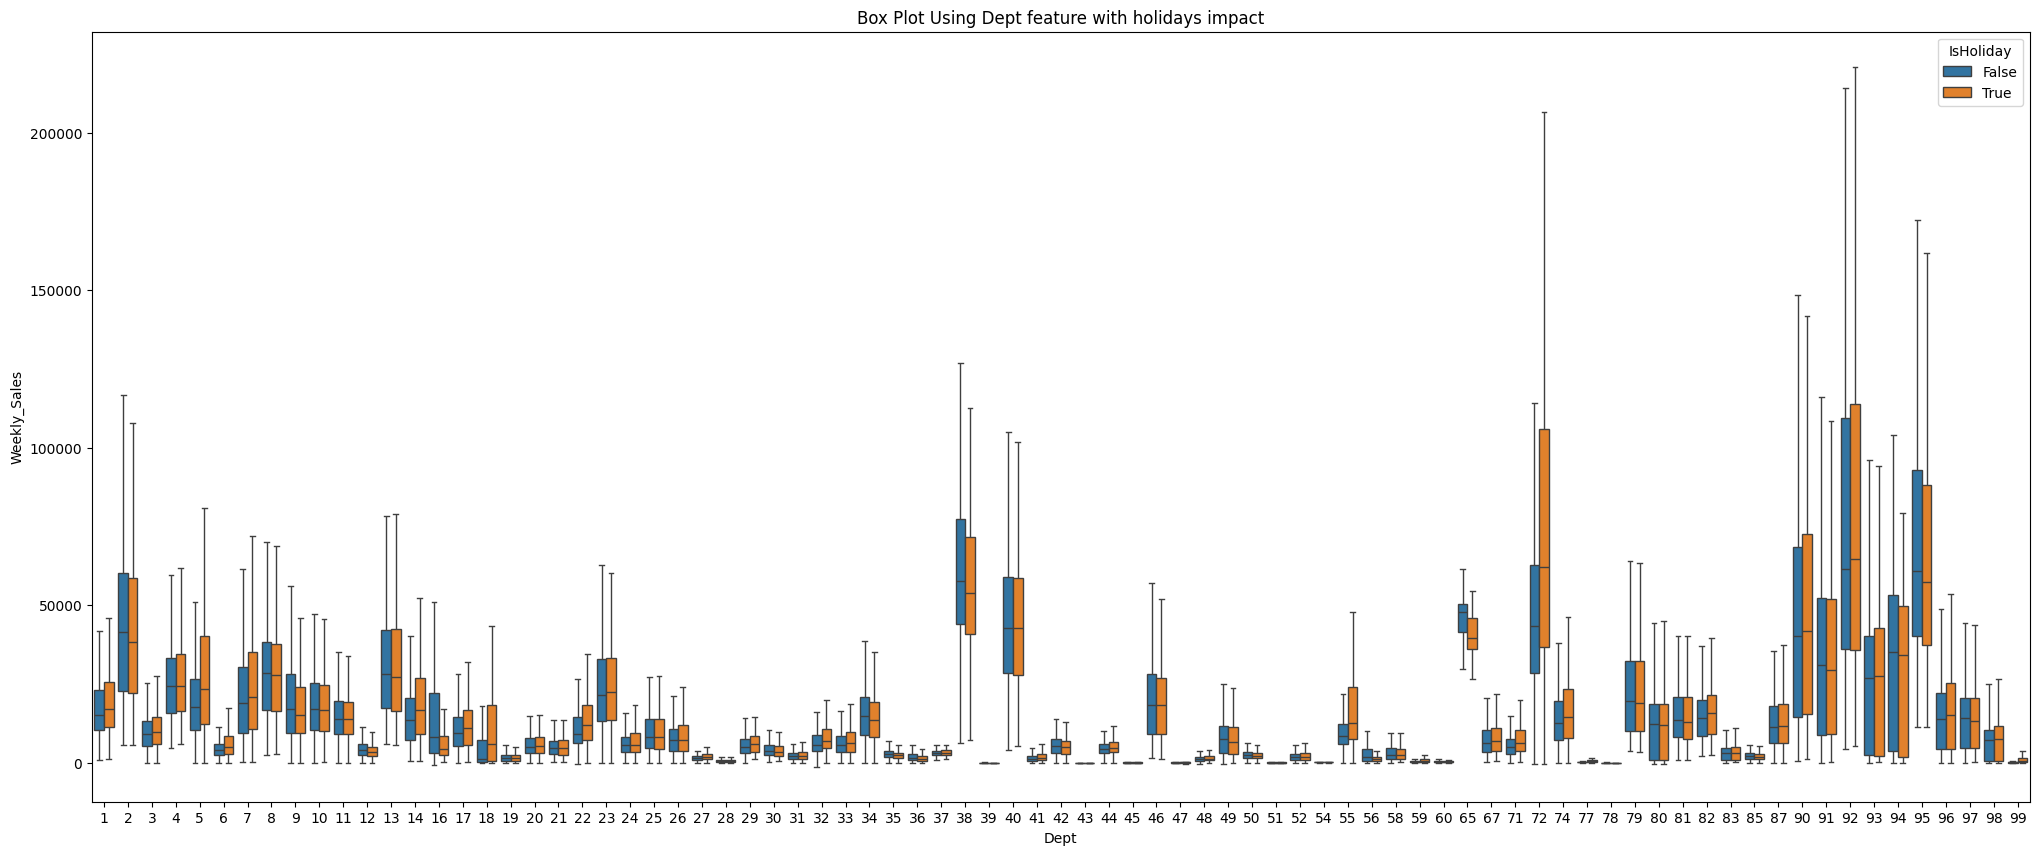

In [35]:
fig, ax = plt.subplots(figsize=(25, 10))
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=train,
                  showfliers=False, hue="IsHoliday")
plt.title("Box Plot Using Dept feature with holidays impact")
plt.show()

same as  type we see the impact of holydays on  department sales 
 some department  are not useful in holidays season

propose that  the personne generally have less money in the end of the mounth  and  more at the begening  so lets see this  if it impact 

In [36]:
train['Is_month_end'] = np.where(train.Day > 22, 1, 0)
train['Is_month_start'] = np.where(train.Day < 7, 1, 0)
train['Is_month_end'] = train['Is_month_end'].astype('bool')
train['Is_month_start'] = train['Is_month_start'].astype('bool')

In [37]:
print("Correlation of Is_month_end feature with weekly_sales")
print(correlation_ratio(train['Is_month_end'], train['Weekly_Sales']))
print(50*'*')
print("Correlation of Is_month_start feature with weekly_sales")
print(correlation_ratio(train['Is_month_start'], train['Weekly_Sales']))
print(50*'*')

Correlation of Is_month_end feature with weekly_sales
5.109982375092706e-06
**************************************************
Correlation of Is_month_start feature with weekly_sales
1.919291806025242e-05
**************************************************


Very less correlation between weekly_sales and These two features

In [38]:
sales_month_end = train['Weekly_Sales'][train['Is_month_end'] == 1]
sales_not_month_end = train['Weekly_Sales'][train['Is_month_end'] == 0]
print("Mean of the sales in month end week: ", np.mean(sales_month_end))
print("Standard devition of the sales in month end week: ", np.std(sales_month_end))
print("Max sales in month end week: ", np.max(sales_month_end))
print("Mean of the sales other than month end week: ",
      np.mean(sales_not_month_end))
print("Standard devition of the sales other than month end week: ",
      np.std(sales_not_month_end))
print("Max sales other than month end week: ", np.max(sales_not_month_end))
print("*"*100)

Mean of the sales in month end week:  16063.6681276195
Standard devition of the sales in month end week:  23601.151162303115
Max sales in month end week:  693099.36
Mean of the sales other than month end week:  15949.275213958324
Standard devition of the sales other than month end week:  22356.130945246805
Max sales other than month end week:  293966.05
****************************************************************************************************


Looking at these data  it can be said that is_month_end have very less value to provide as it's max is very high compared to normal week that's why it's mean is high.

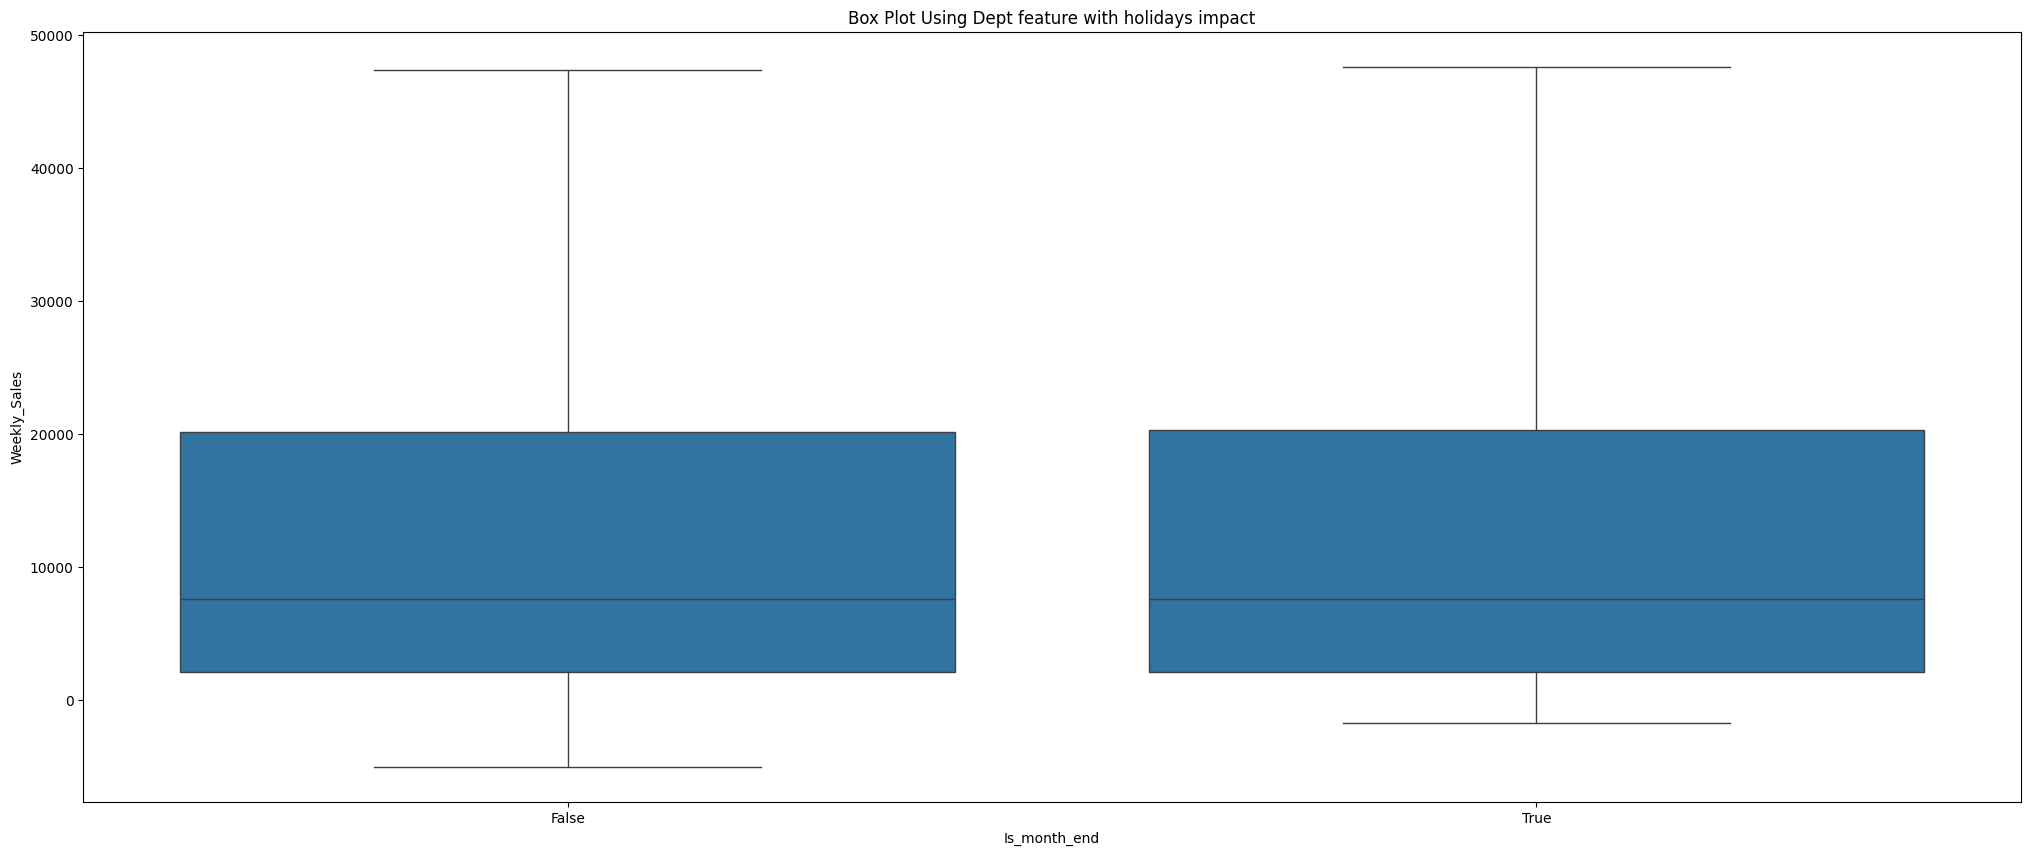

In [39]:
fig, ax = plt.subplots(figsize=(25, 10))
fig = sns.boxplot(x='Is_month_end', y='Weekly_Sales',
                  data=train, showfliers=False)
plt.title("Box Plot Using Dept feature with holidays impact")
plt.show()

feature is not useful

In [40]:

sales_month_start = train['Weekly_Sales'][train['Is_month_start'] == 1]
sales_not_month_start = train['Weekly_Sales'][train['Is_month_start'] == 0]
print("Mean of the sales in month start week: ", np.mean(sales_month_start))
print("Standard devition of the sales in month start week: ",
      np.std(sales_month_start))
print("Max sales in month start week: ", np.max(sales_month_start))
print("Mean of the sales other than month start week: ",
      np.mean(sales_not_month_start))
print("Standard devition of the sales other than month start week: ",
      np.std(sales_not_month_start))
print("Max sales other than month start week: ", np.max(sales_not_month_start))
print("*"*100)

Mean of the sales in month start week:  16178.467199541716
Standard devition of the sales in month start week:  22668.762563068187
Max sales in month start week:  293966.05
Mean of the sales other than month start week:  15931.059406875496
Standard devition of the sales other than month start week:  22721.66187138904
Max sales other than month start week:  693099.36
****************************************************************************************************


It has more value than month end feature

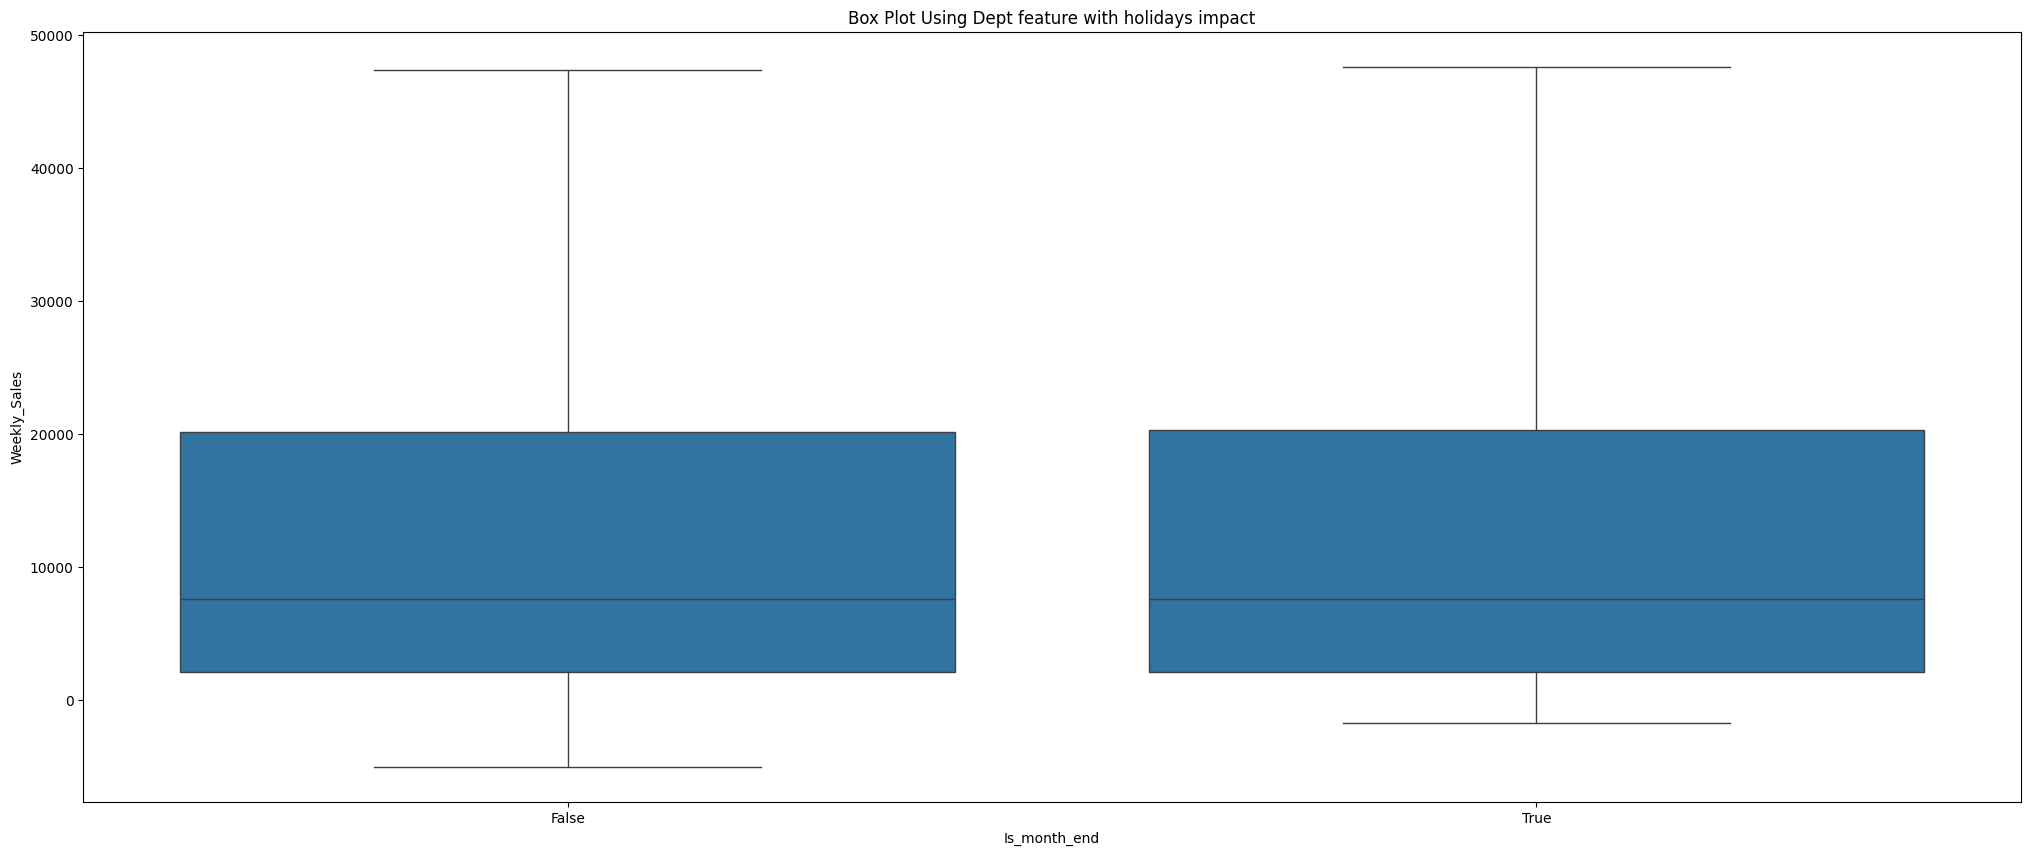

In [41]:
fig, ax = plt.subplots(figsize=(25, 10))
fig = sns.boxplot(x='Is_month_end', y='Weekly_Sales',
                  data=train, showfliers=False)
plt.title("Box Plot Using Dept feature with holidays impact")
plt.show()

still not  not useful

weekly_sales

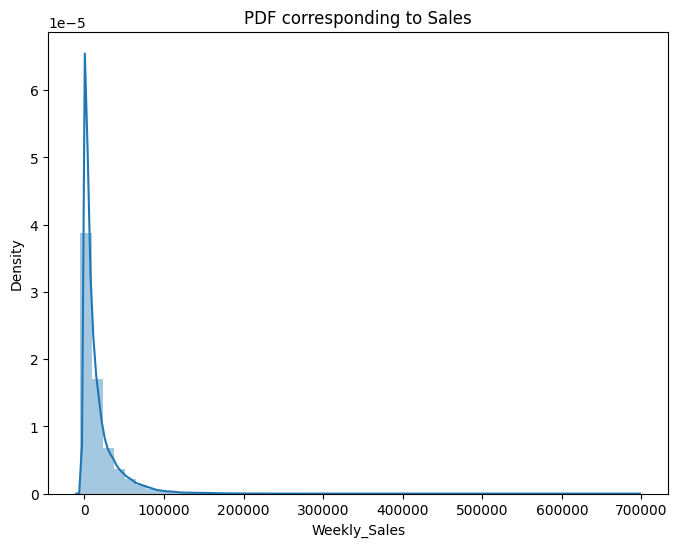

In [42]:

fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['Weekly_Sales'])
plt.title("PDF corresponding to Sales")
plt.show()

Most of the week have sales between 0 to 20000.

[9.56244515e-01 3.93054534e-02 4.09659131e-03 2.49068957e-04
 4.50696207e-05 4.26975354e-05 7.11625590e-06 0.00000000e+00
 0.00000000e+00 9.48834120e-06]
[ -4988.94  64819.89 134628.72 204437.55 274246.38 344055.21 413864.04
 483672.87 553481.7  623290.53 693099.36]


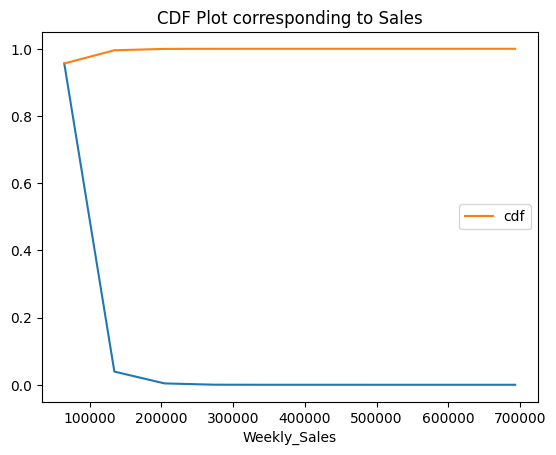

In [43]:
counts, bin_edges = np.histogram(train['Weekly_Sales'], bins=10, density=False)
pdf = counts/sum(counts)
print(pdf)
print(bin_edges)
cdf = np.cumsum(pdf)
plot, = plt.plot(bin_edges[1:], pdf)
plot1, = plt.plot(bin_edges[1:], cdf)
plt.xlabel('Weekly_Sales')
plt.title("CDF Plot corresponding to Sales")
plt.legend([plot1], ['cdf'])
plt.show()

Almost 90 percent time sales are below 150000

In [44]:
print("Skewness: ", train['Weekly_Sales'].skew())
print("Kurtosis: ", train['Weekly_Sales'].kurt())

Skewness:  3.2620081854656657
Kurtosis:  21.49128990832619


most sales month november and december


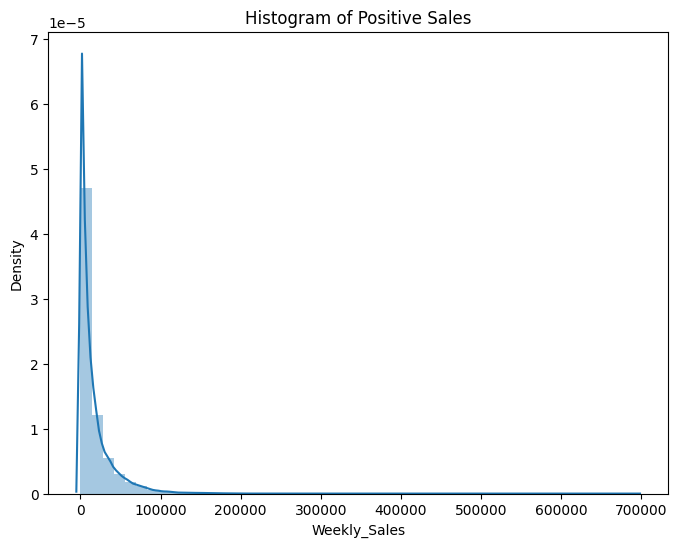

In [45]:
positive_sales = train[train['Weekly_Sales'] > 0]['Weekly_Sales']
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(positive_sales)
plt.title("Histogram of Positive Sales")
plt.show()

Not much to conclude from it

Markdown

In [46]:
#sns.pairplot(train, vars=['Weekly_Sales', 'MarkDown1',
#             'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

 if these markdown do not provide much value then they can be droped 

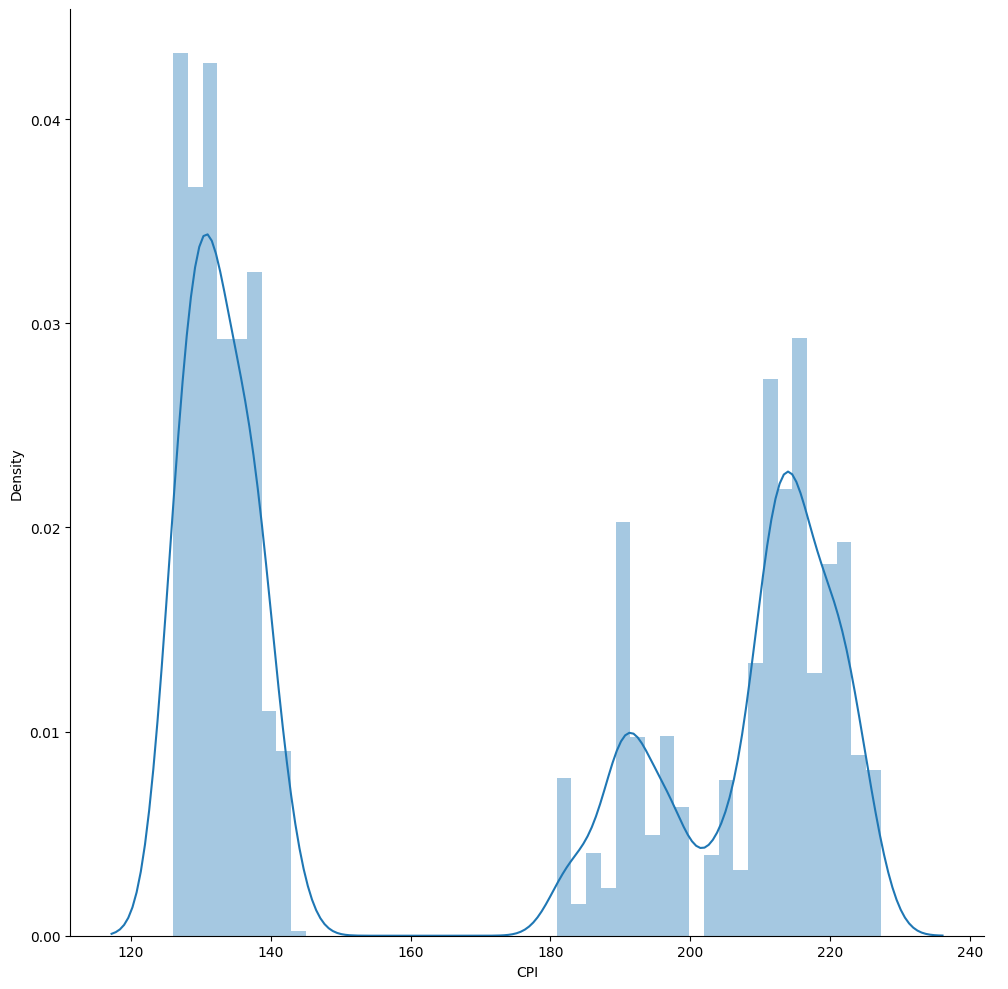

In [47]:
sns.FacetGrid(train, height=10).map(sns.distplot, "CPI").add_legend()
plt.savefig("CPI_distplot.png")




plt.show()

between 150 to 170  value of CPI there is no datapoint.

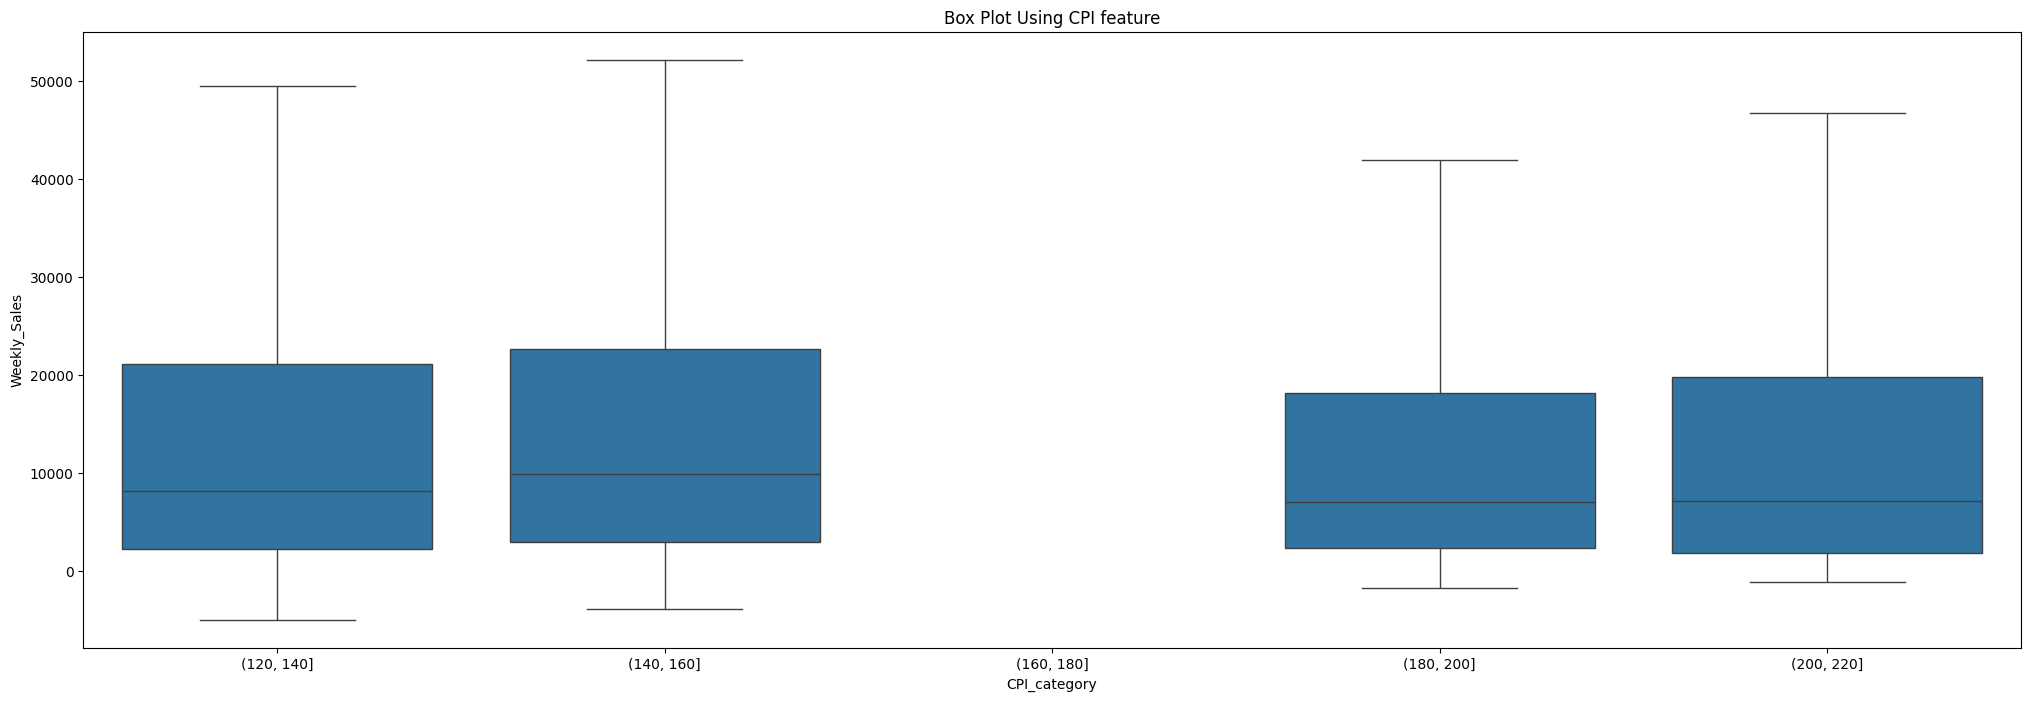

In [48]:
train['CPI_category'] = pd.cut(
    train['CPI'], bins=[120, 140, 160, 180, 200, 220])
fig, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='CPI_category', y='Weekly_Sales',
                  data=train, showfliers=False)
plt.title("Box Plot Using CPI feature")
plt.savefig("CPI_Box_plot.png")

plt.show()

not much difference while change in the CPI during the given period.

<function matplotlib.pyplot.show(close=None, block=None)>

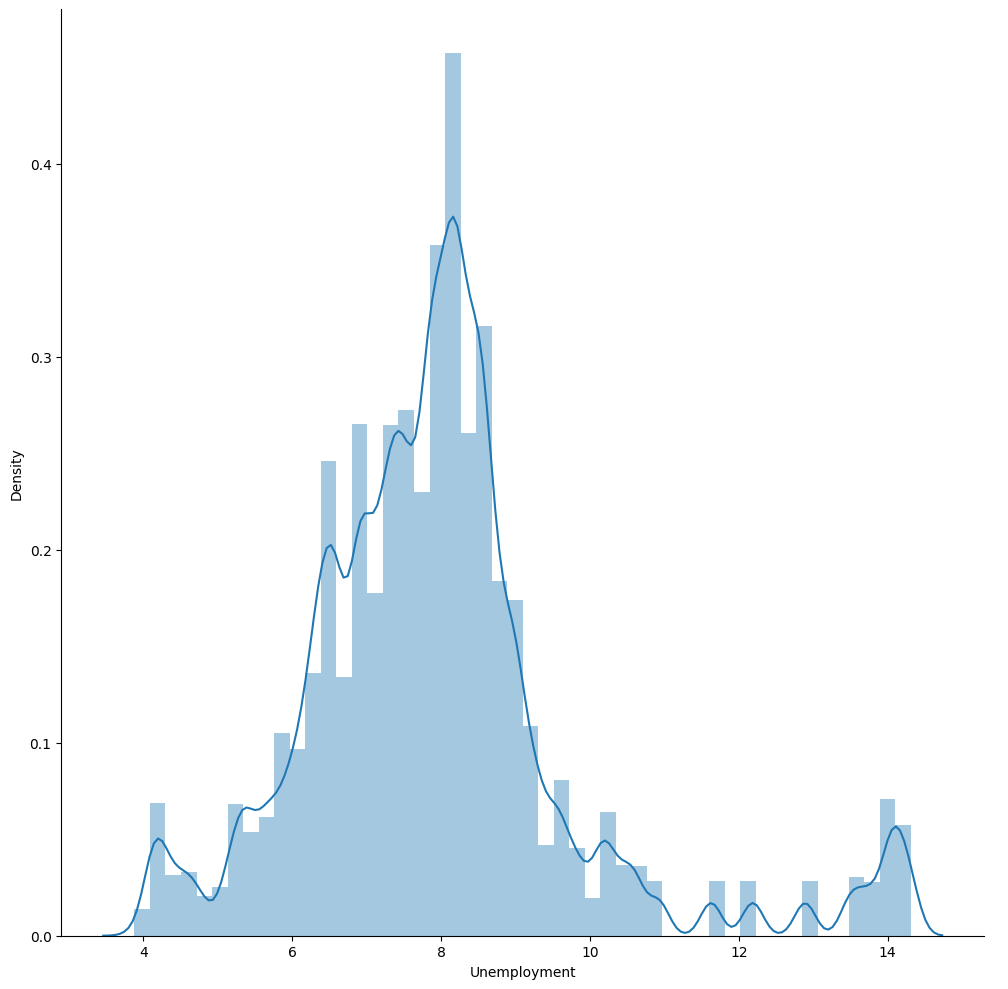

In [49]:
sns.FacetGrid(train, height=10).map(sns.distplot, "Unemployment").add_legend()
plt.savefig("Unemployment_distplot.png")



plt.show

 Most of the point lies when umployement rate is 8.

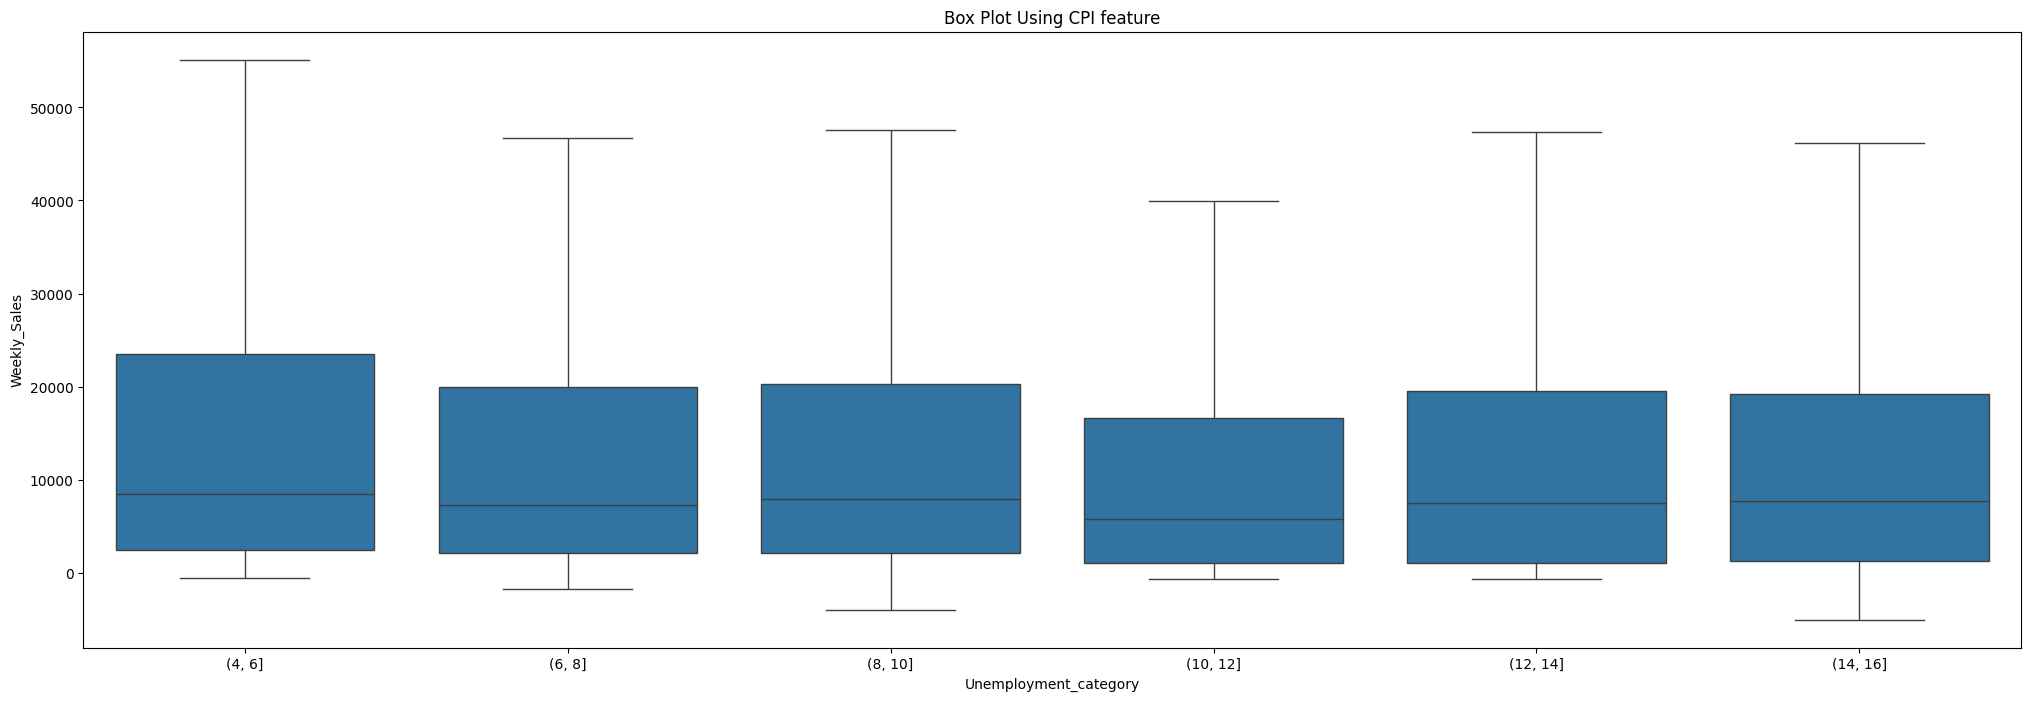

In [50]:
train['Unemployment_category'] = pd.cut(
    train['Unemployment'], bins=[4, 6, 8, 10, 12, 14, 16])
fig, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Unemployment_category', y='Weekly_Sales',
                  data=train, showfliers=False)
plt.title("Box Plot Using CPI feature")
plt.savefig("Unemployment_Box_plot.png")

plt.show()

Mean value of all box plot range are comparartively equal so it is not useful

<function matplotlib.pyplot.show(close=None, block=None)>

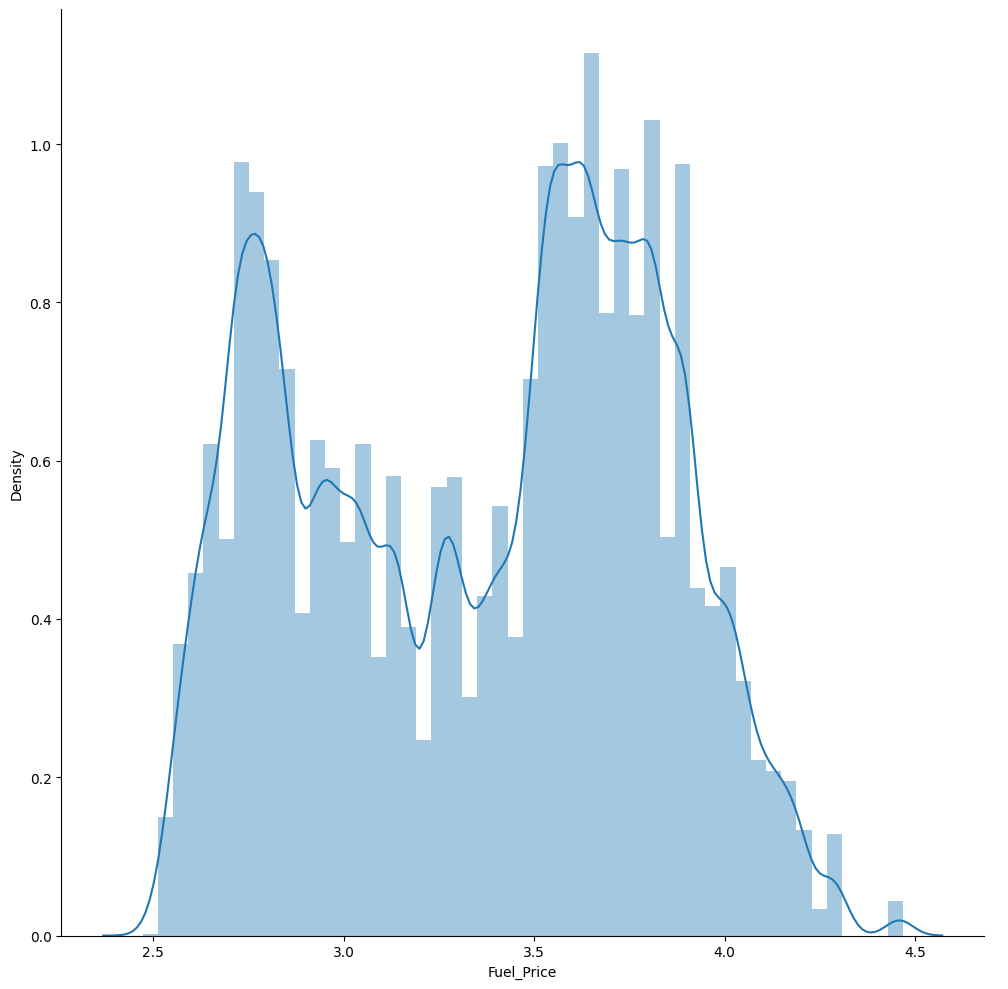

In [51]:
sns.FacetGrid(train, height=10).map(sns.distplot, "Fuel_Price").add_legend()
plt.savefig("Fuel_Price_distplot.png")



plt.show

 Here it looks no of datapoints are higher when fuel rate was between 3.5 to 4.0 and 2.5-3.0 

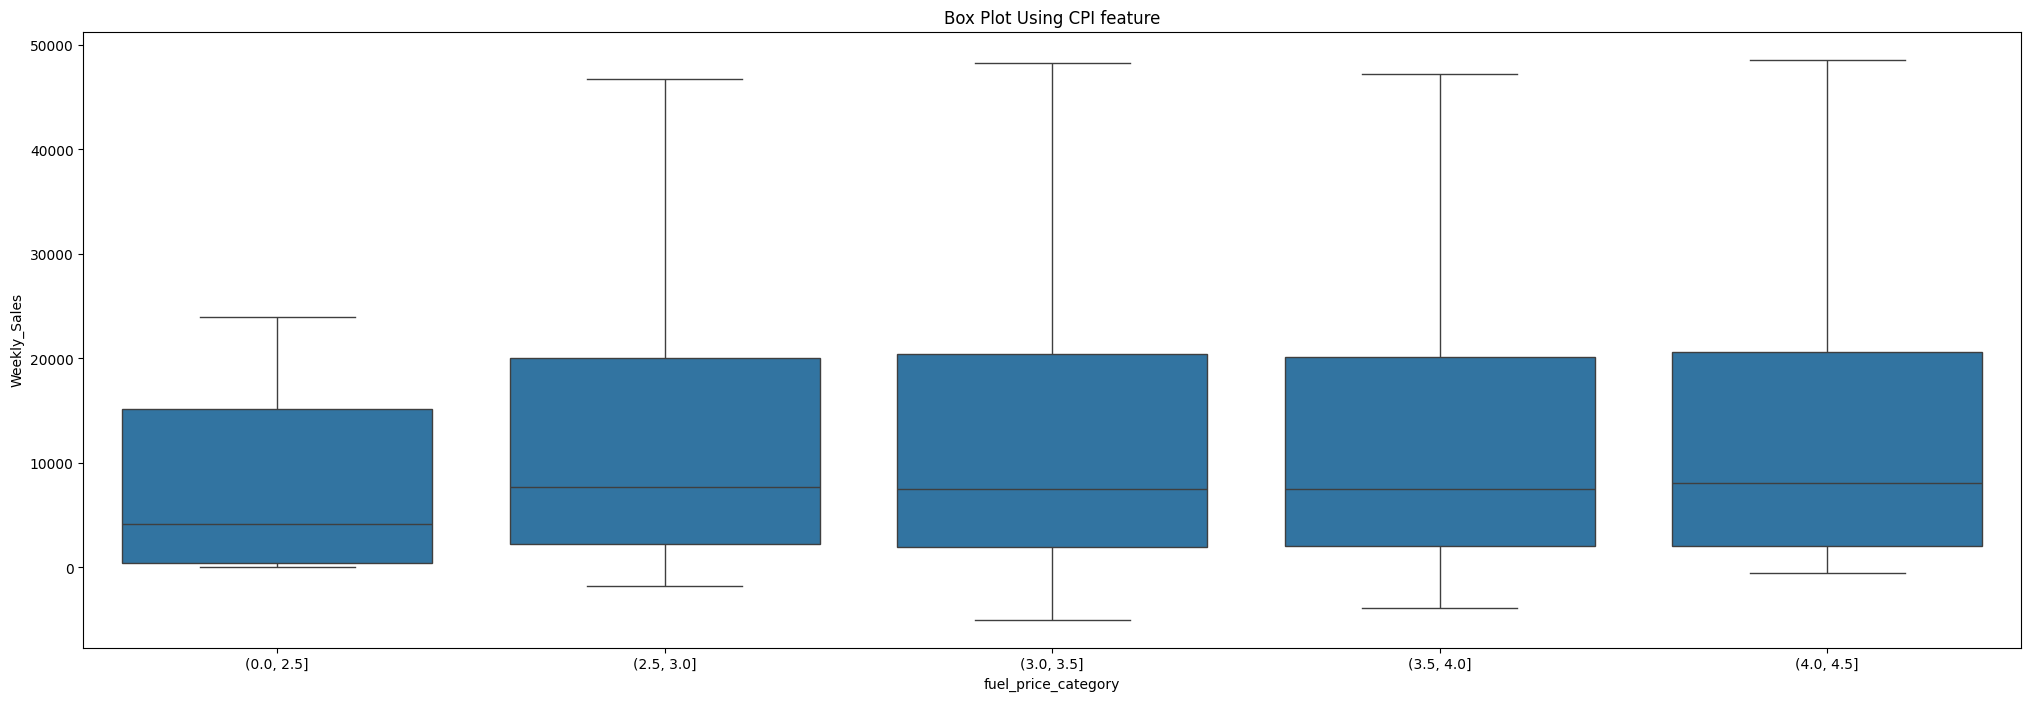

In [52]:
train['fuel_price_category'] = pd.cut(
    train['Fuel_Price'], bins=[0, 2.5, 3, 3.5, 4, 4.5])
fig, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='fuel_price_category', y='Weekly_Sales',
                  data=train, showfliers=False)
plt.title("Box Plot Using CPI feature")
plt.savefig("Fuel_Price_Box_plot.png")

plt.show()

Fuel price has very less impact on sales as there is no change in sales as price increasing.So this feature can also be removed.

<function matplotlib.pyplot.show(close=None, block=None)>

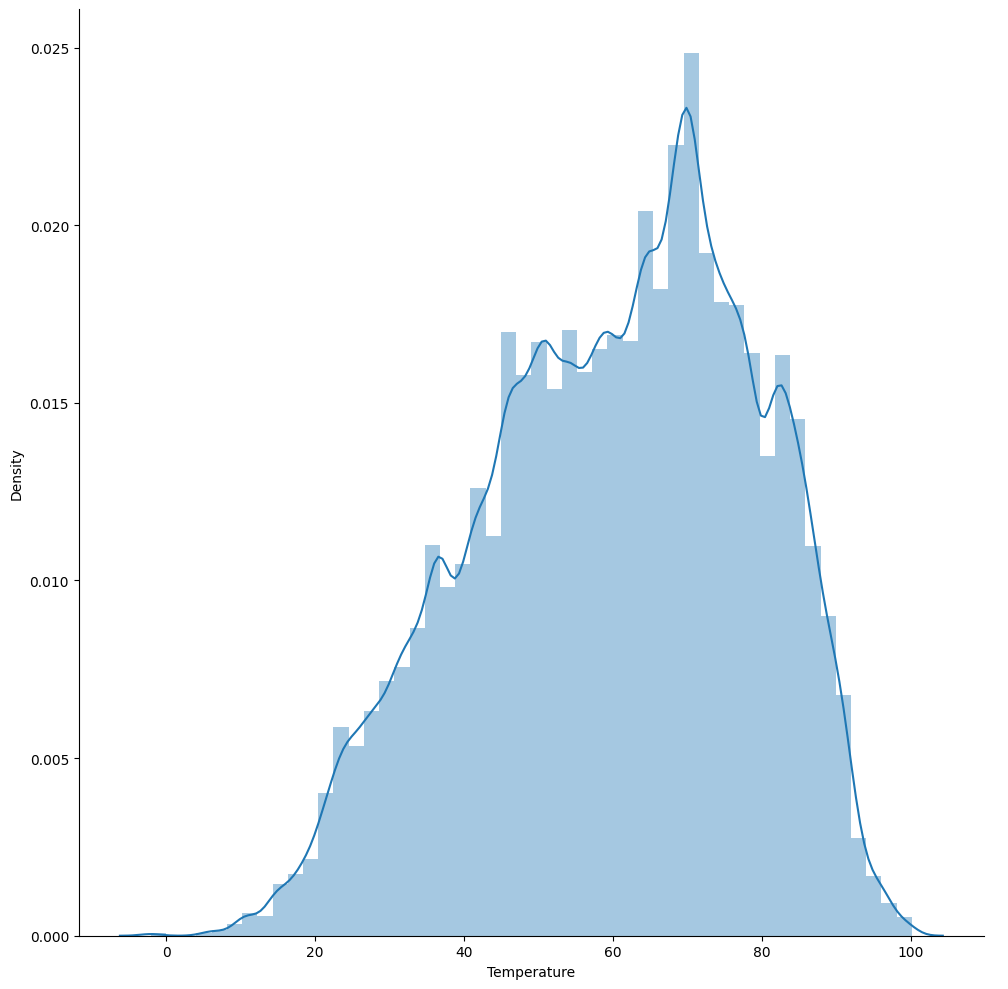

In [53]:

sns.FacetGrid(train, height=10).map(sns.distplot, "Temperature").add_legend()
plt.savefig("Temperature_distplot.png")

plt.show

 most of the data point lies in 60-80 F temperatures assuming most of the sales also happens here.

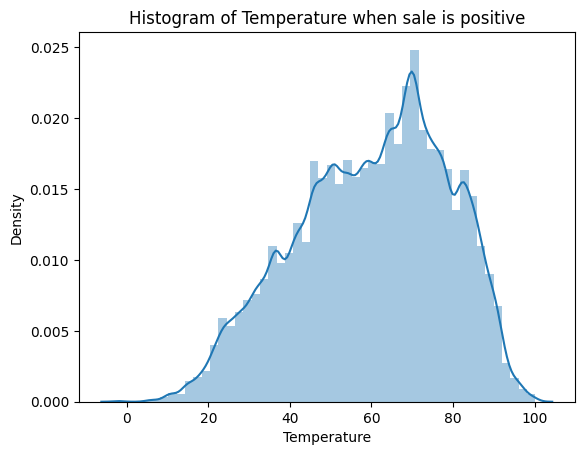

In [54]:
positive_temperature = train[train['Weekly_Sales'] > 0]['Temperature']
sns.distplot(positive_temperature)
plt.title("Histogram of Temperature when sale is positive")
plt.show()

60-80 F temperature have more number of times of sale.

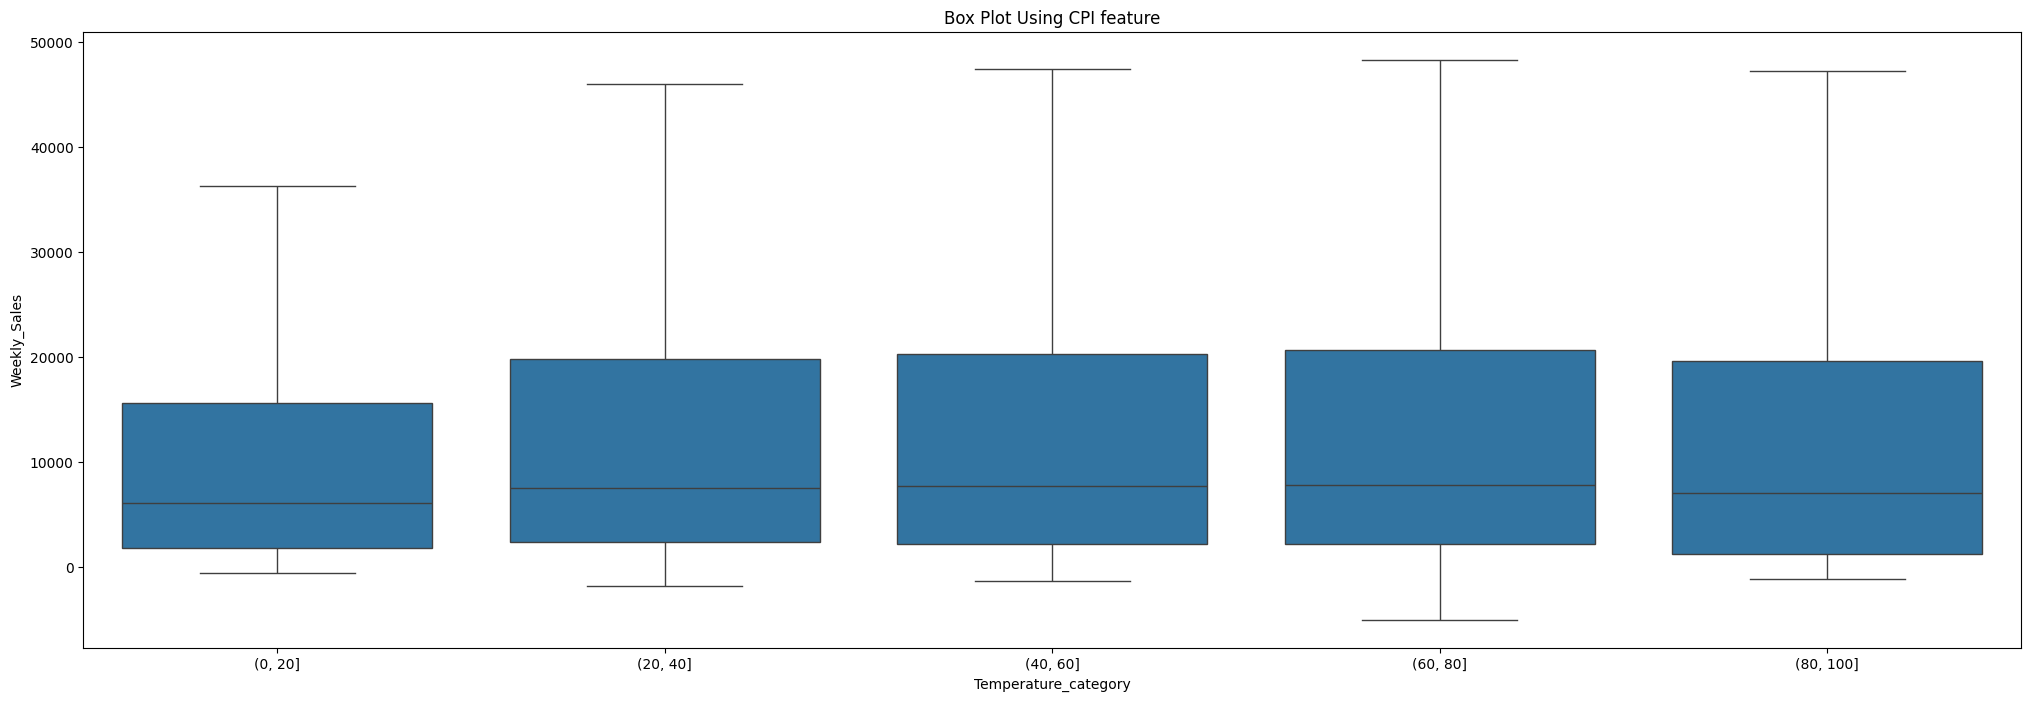

In [55]:
train['Temperature_category'] = pd.cut(
    train['Temperature'], bins=[0, 20, 40, 60, 80, 100])
fig, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Temperature_category', y='Weekly_Sales',
                  data=train, showfliers=False)
plt.title("Box Plot Using CPI feature")
plt.savefig("Temperature_Box_plot.png")

plt.show()

60-80 temperature have almost same sale as in other category of temperature.So this feature can also be removed

so  temperature  and  CPI umployement Fuel price not useful  apperntly  we will remove it 


In [56]:
import holidays

dates =[]
for ptr in holidays.US(years = 2010).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2011).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2012).items():
    dates.append(ptr[0])
holidays=[] 
for index, row in train.iterrows():
    dat = train['Date'][index]
    dt=[]
    for i in range(0,5):
        dt.append(dat - datetime.timedelta(days = i))
    for i in range(1,3):
        dt.append(dat + datetime.timedelta(days = i))
    count = 0
    for date in dates:
        if date in dt:
            count +=1
    holidays.append(count)
    
train['Holidays'] = np.array(holidays)


In [ ]:
sns.countplot(train['Holidays'])
plt.title("Holidays Distrbutions")
plt.show()

 There are very less week with 2 holidays and most of the week have no holidays. 
 

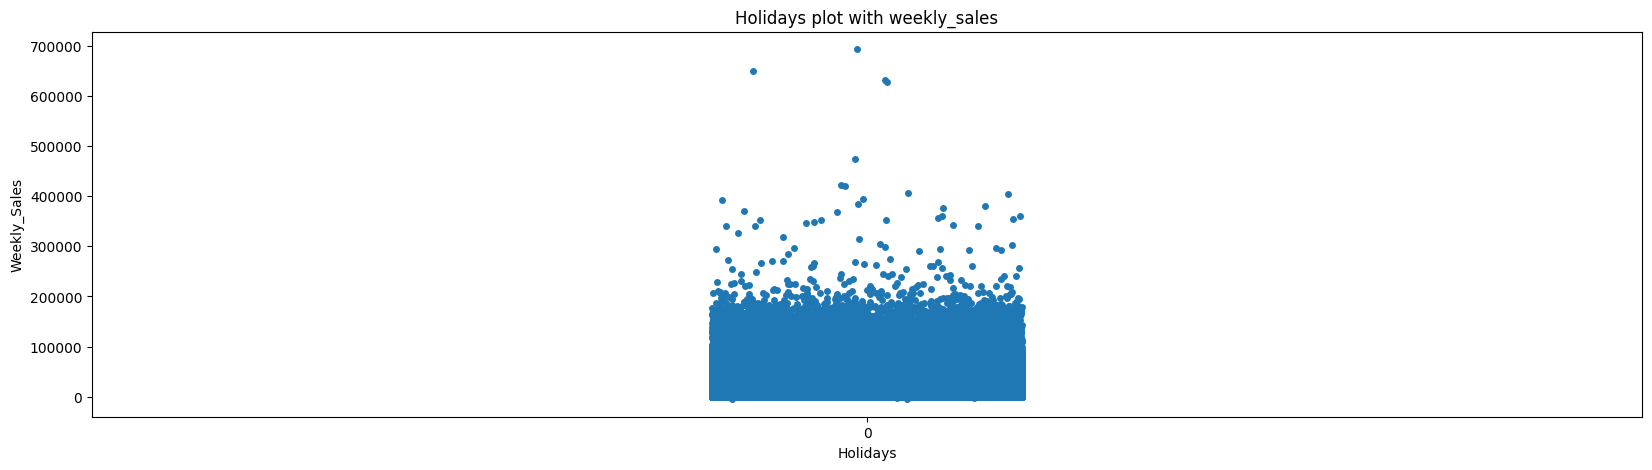

In [60]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.stripplot(y=train['Weekly_Sales'], x=train['Holidays'])
plt.title("Holidays plot with weekly_sales")
plt.show()

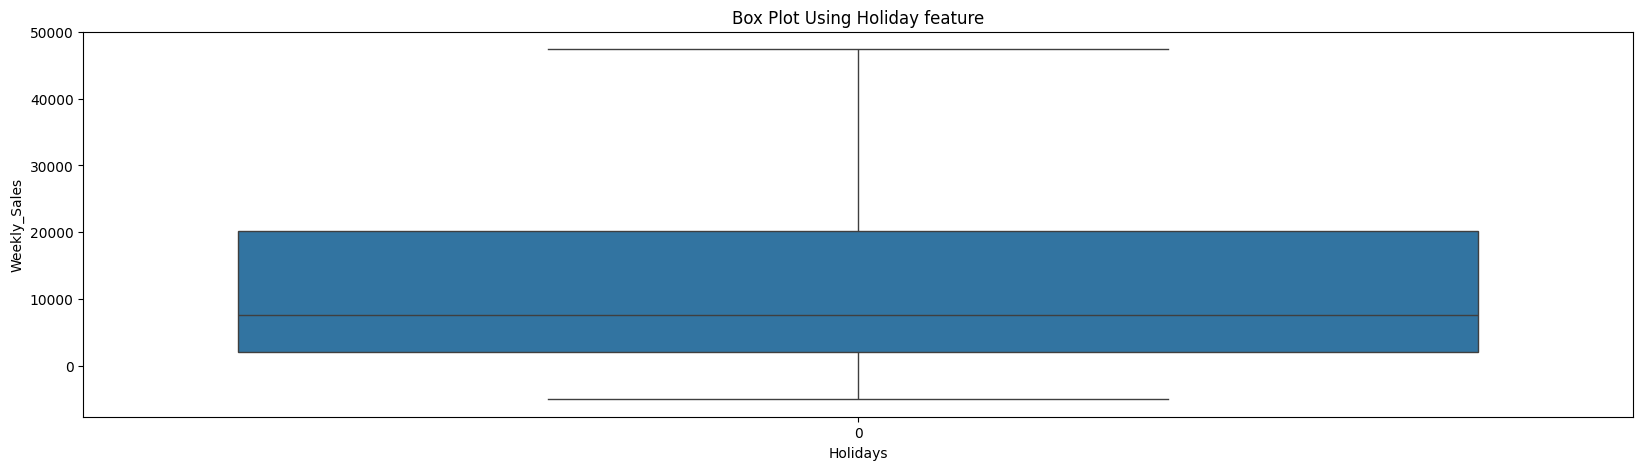

In [61]:

fig, ax = plt.subplots(figsize=(20, 5))
fig = sns.boxplot(x='Holidays', y='Weekly_Sales', data=train, showfliers=False)
plt.title("Box Plot Using Holiday feature")
plt.show()

When Holidays are two in  a week then weekly_sales are bit higher.

In [62]:
g = train.groupby(["Month","Store"])
monthly_averages = g.aggregate({"Weekly_Sales":np.mean})
store_value=monthly_averages.loc[monthly_averages.groupby('Month')['Weekly_Sales'].idxmax()]
print("Stores which have highest value during that  Month: ")
store_value


Stores which have highest value during that  Month: 


,,Weekly_Sales
Month,Store,
1,4,26745.425906
2,20,30464.008370
3,14,28363.344793
4,14,29467.913047
5,14,29231.265922
6,20,29803.121209
7,20,28857.317280
8,4,29082.862586
9,4,27925.529893


It can be seen that 20 stores are more prominent than all others. Store 20 has highest Sale during Thanksgiving and Christmas which were more impactful than Labour's Day and Super Bowl


In [63]:
def create_Holiday_Type(df):
    def create_holiday_type_column(df, dates, holiday_type, name):
        df.loc[
            df['Date'].isin(dates),
            'HolidayType'
        ] = holiday_type

    df['HolidayType'] = -1
    
    holiday_list = [
        (['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'], 'Super_Bowl'),
        (['2010-09-10','2011-09-09', '2012-09-07', '2013-09-06'], 'Labor_Day'),
        (['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'], 'Thanksgiving'),
        (['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'], 'Christmas')
    ]
    
    for index in range(0, len(holiday_list)):
        holiday = holiday_list[index]
        create_holiday_type_column(df, holiday[0], index, holiday[1])
    
    for x in df:
        if df[x].dtypes == "int64":
            df[x] = df[x].astype(float)

            
create_Holiday_Type(train)



 !! sales in holiday week are more than sales in non-holiday week
 and now check if there is any trend in the year 


In [64]:

train.isnull().mean()

Store                    0.000000
Dept                     0.000000
Date                     0.000000
Weekly_Sales             0.000000
IsHoliday                0.000000
Year                     0.000000
Month                    0.000000
Week                     0.000000
Day                      0.000000
n_days                   0.000000
Temperature              0.000000
Fuel_Price               0.000000
MarkDown1                0.642572
MarkDown2                0.736110
MarkDown3                0.674808
MarkDown4                0.679847
MarkDown5                0.640790
CPI                      0.000000
Unemployment             0.000000
Type                     0.000000
Size                     0.000000
Is_month_end             0.000000
Is_month_start           0.000000
CPI_category             0.092713
Unemployment_category    0.000681
fuel_price_category      0.000000
Temperature_category     0.000377
Holidays                 0.000000
HolidayType              0.000000
dtype: float64

In [79]:
# Handling Markdown features
for i in range(1, 6):
    column_name = "MarkDown" + str(i)
    features[column_name] = features[column_name].apply(
        lambda x: 0 if x < 0 else x)
    features[column_name].fillna(value=0, inplace=True)

 Through this you can see that Markdown values have high percentage of Nan values.

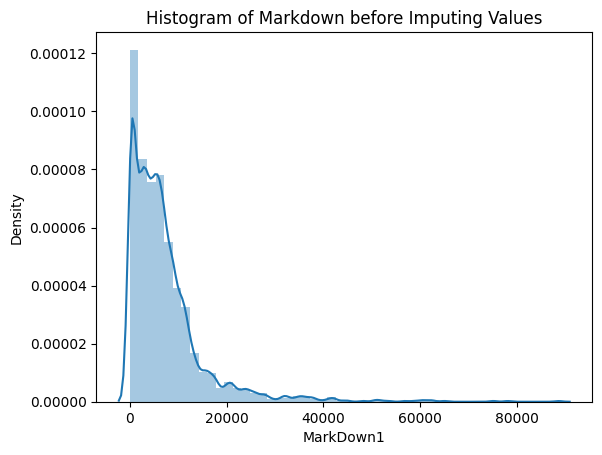

In [71]:
sns.distplot(train['MarkDown1'])
plt.title("Histogram of Markdown before Imputing Values")
plt.show()

In [74]:
train.describe

<bound method NDFrame.describe of         Store  Dept       Date  Weekly_Sales  IsHoliday  Year  Month  Week  \
0         1.0   1.0 2010-02-05      24924.50      False  2010      2     5   
1         1.0   1.0 2010-02-12      46039.49       True  2010      2     6   
2         1.0   1.0 2010-02-19      41595.55      False  2010      2     7   
3         1.0   1.0 2010-02-26      19403.54      False  2010      2     8   
4         1.0   1.0 2010-03-05      21827.90      False  2010      3     9   
...       ...   ...        ...           ...        ...   ...    ...   ...   
421565   45.0  98.0 2012-09-28        508.37      False  2012      9    39   
421566   45.0  98.0 2012-10-05        628.10      False  2012     10    40   
421567   45.0  98.0 2012-10-12       1061.02      False  2012     10    41   
421568   45.0  98.0 2012-10-19        760.01      False  2012     10    42   
421569   45.0  98.0 2012-10-26       1076.80      False  2012     10    43   

        Day  n_days  ...  Typ

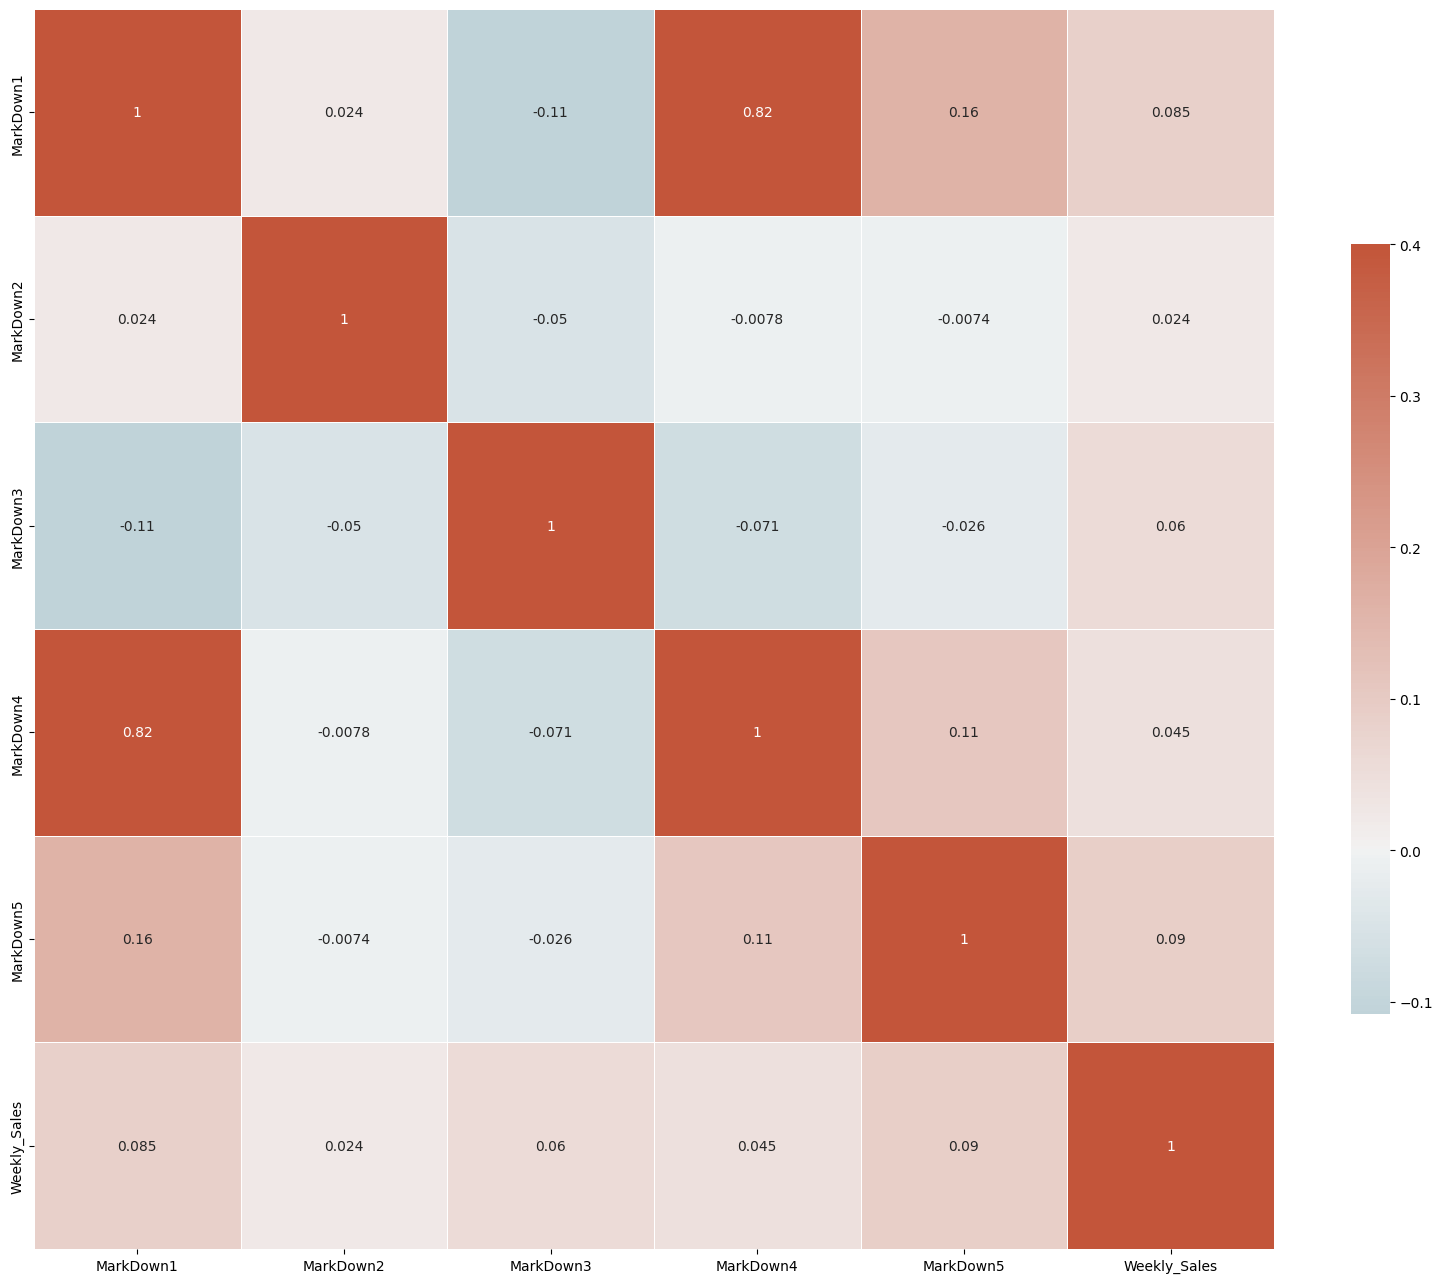

In [80]:
data = pd.concat([train['MarkDown1'],train['MarkDown2'],train['MarkDown3'],train['MarkDown4'],
                  train['MarkDown5'],train['Weekly_Sales']], axis=1)
corr = data.corr()
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.4, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

Now Markdown Values are very less correlated to Weekly_sales .And markdown 1 and markdown4 are also higly correlated .So We can drop them

Let's check which models performs best using WMAE as performance metrics to rule out all the Bad models for hyper parameter tuning


Preprocess Data for Training.

In [92]:
train = train[train['Weekly_Sales'] > 0]
data = train[['Store', 'Size', 'Dept', 'Month', 'Type', 'Year', 'Week',
              'Day', 'n_days', 'IsHoliday', 'Holidays', 'HolidayType', 'CPI']]
data['Type'] = data['Type'].astype('category')
data['Type'] = data['Type'].cat.codes

X = data
Y = train['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(
   X ,Y , test_size=0.2)
t = StandardScaler()
t.fit(X_train)
train_data = t.transform(X_train)
test_data = t.transform(X_test)

In [82]:
test.head


<bound method NDFrame.head of         Store  Dept       Date  IsHoliday
0           1     1 2012-11-02      False
1           1     1 2012-11-09      False
2           1     1 2012-11-16      False
3           1     1 2012-11-23       True
4           1     1 2012-11-30      False
...       ...   ...        ...        ...
115059     45    98 2013-06-28      False
115060     45    98 2013-07-05      False
115061     45    98 2013-07-12      False
115062     45    98 2013-07-19      False
115063     45    98 2013-07-26      False

[115064 rows x 4 columns]>

In [83]:
print(test['Date'].dtype)

datetime64[ns]


In [84]:
stores.info

<bound method DataFrame.info of     Store Type    Size
0       1    A  151315
1       2    A  202307
2       3    B   37392
3       4    A  205863
4       5    B   34875
5       6    A  202505
6       7    B   70713
7       8    A  155078
8       9    B  125833
9      10    B  126512
10     11    A  207499
11     12    B  112238
12     13    A  219622
13     14    A  200898
14     15    B  123737
15     16    B   57197
16     17    B   93188
17     18    B  120653
18     19    A  203819
19     20    A  203742
20     21    B  140167
21     22    B  119557
22     23    B  114533
23     24    A  203819
24     25    B  128107
25     26    A  152513
26     27    A  204184
27     28    A  206302
28     29    B   93638
29     30    C   42988
30     31    A  203750
31     32    A  203007
32     33    A   39690
33     34    A  158114
34     35    B  103681
35     36    A   39910
36     37    C   39910
37     38    C   39690
38     39    A  184109
39     40    A  155083
40     41    A  196321
41

Preprocess data for Testing.

In [85]:
print(test.columns)


Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')


In [86]:
import holidays
import datetime
import numpy as np

# Assuming you already have 'create_Holiday_Type' function defined

# Create Holiday Type
create_Holiday_Type(test)

# Extract Date features
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].dt.isocalendar().week
test['Day'] = test['Date'].dt.day
test['n_days'] = (test['Date'].dt.date -
                  train['Date'].dt.date.min()).apply(lambda x: x.days)

# Merge with Stores based on Store and Date (excluding IsHoliday)
# Merge test with features and stores dataframes
test = pd.merge(test, features, on=['Store', 'Date', 'IsHoliday'], how='left')
test = pd.merge(test, stores, on=['Store'], how='left')

# Display the first few rows of the merged dataframe
print(test.head())


# Determine Holidays
dates = []
for ptr in holidays.US(years=2010).items():
    dates.append(ptr[0])
for ptr in holidays.US(years=2011).items():
    dates.append(ptr[0])
for ptr in holidays.US(years=2012).items():
    dates.append(ptr[0])

holidays_count = []
for index, row in test.iterrows():
    dat = row['Date']
    dt = []
    for i in range(0, 5):
        dt.append(dat - datetime.timedelta(days=i))
    for i in range(1, 3):
        dt.append(dat + datetime.timedelta(days=i))
    count = 0
    for date in dates:
        if date in dt:
            count += 1
    holidays_count.append(count)

# Add Holidays column to the DataFrame
test['Holidays'] = np.array(holidays_count)

# Select the required columns and convert 'Type' to categorical codes
# Select the required columns and convert 'Type' to categorical codes
data_test = test[['Store', 'Size', 'Dept', 'Month', 'Type', 'Year',
                  'Week', 'Day', 'n_days', 'IsHoliday', 'Holidays', 'HolidayType', 'CPI']]

data_test['Type'] = data_test['Type'].astype('category')
data_test['Type'] = data_test['Type'].cat.codes

   Store  Dept       Date  IsHoliday  HolidayType  Year  Month  Week  Day  \
0    1.0   1.0 2012-11-02      False         -1.0  2012     11    44    2   
1    1.0   1.0 2012-11-09      False         -1.0  2012     11    45    9   
2    1.0   1.0 2012-11-16      False         -1.0  2012     11    46   16   
3    1.0   1.0 2012-11-23       True          2.0  2012     11    47   23   
4    1.0   1.0 2012-11-30      False         -1.0  2012     11    48   30   

   n_days  ...  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0    1001  ...       3.386    6766.44    5147.70      50.82    3639.90   
1    1008  ...       3.314   11421.32    3370.89      40.28    4646.79   
2    1015  ...       3.252    9696.28     292.10     103.78    1133.15   
3    1022  ...       3.211     883.59       4.17   74910.32     209.91   
4    1029  ...       3.207    2460.03       0.00    3838.35     150.57   

   MarkDown5         CPI  Unemployment  Type    Size  
0    2737.42  223.462779         6.57

In [87]:
# List of columns to drop
columns_to_drop = ['Fuel_Price', 'MarkDown1', 'MarkDown2',
                   'MarkDown3', 'MarkDown4', 'MarkDown5', 'Unemployment', 'Temperature']

# Drop the specified columns from the DataFrame
test = test.drop(columns=columns_to_drop)

print(test.columns)

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'HolidayType', 'Year', 'Month',
       'Week', 'Day', 'n_days', 'CPI', 'Type', 'Size', 'Holidays'],
      dtype='object')


In [88]:
model_list = {'linear regression': SGDRegressor(), 'SVR': SGDRegressor(loss='epsilon_insensitive'),
              'RidgeCV': RidgeCV(), 'ElasticNet': ElasticNet(),
              'RandomForest': RandomForestRegressor(), 'XGboost': lgb.LGBMRegressor()}



In [89]:
for model_name, model in model_list.items():
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    print('WMAE score of ', model_name, ' : ', WMAE(X_test, y_test, predicted))
    print(100*'-')

WMAE score of  linear regression  :  9.580502824564138e+16
----------------------------------------------------------------------------------------------------
WMAE score of  SVR  :  46777.61
----------------------------------------------------------------------------------------------------
WMAE score of  RidgeCV  :  210239.74
----------------------------------------------------------------------------------------------------
WMAE score of  ElasticNet  :  14817.27
----------------------------------------------------------------------------------------------------
WMAE score of  RandomForest  :  1435.33
----------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of d

RandomForest and XGboost are most best model out of all.


Random Forest Regressor

In [90]:
#n_estimators = [100, 120, 140]
#max_depth = [25, 27, 30]
#random_forest(n_estimators, max_depth)

In [93]:
RF = RandomForestRegressor(n_estimators=100, max_depth=27)
RF.fit(X, Y)
print(data.info)

print(RF.score(X, Y))

<bound method DataFrame.info of         Store      Size  Dept  Month  Type  Year  Week  Day  n_days  \
0         1.0  151315.0   1.0      2     0  2010     5    5     0.0   
1         1.0  151315.0   1.0      2     0  2010     6   12     7.0   
2         1.0  151315.0   1.0      2     0  2010     7   19    14.0   
3         1.0  151315.0   1.0      2     0  2010     8   26    21.0   
4         1.0  151315.0   1.0      3     0  2010     9    5    28.0   
...       ...       ...   ...    ...   ...   ...   ...  ...     ...   
421565   45.0  118221.0  98.0      9     1  2012    39   28   966.0   
421566   45.0  118221.0  98.0     10     1  2012    40    5   973.0   
421567   45.0  118221.0  98.0     10     1  2012    41   12   980.0   
421568   45.0  118221.0  98.0     10     1  2012    42   19   987.0   
421569   45.0  118221.0  98.0     10     1  2012    43   26   994.0   

        IsHoliday  Holidays  HolidayType         CPI  
0           False         0         -1.0  211.096358  
1    

In [94]:
def predict_Sales(model, number, data_test, test):
    predicted = model.predict(data_test)
    column1 = []
    column2 = []
    for index, row in test.iterrows():
        store = str(int(test['Store'][index]))
        dept = str(int(test['Dept'][index]))
        date = str(test['Date'][index]).split(" ")[0]
        value = predicted[index]
        a = store+"_"+dept+"_"+date
        column1.append(a)
        column2.append(value)

    col = {'Id': column1, 'Weekly_Sales': column2}
    test_df = pd.DataFrame(data=col)
    string = "resultat_de_predection_" + number + ".csv"
    test_df.to_csv(string, index=False)

In [95]:
predict_Sales(RF, '1', data_test, test)

In [96]:
X_test_single = np.array([X_test.iloc[0]])
X_test_single 
X_test.describe

<bound method NDFrame.describe of         Store      Size  Dept  Month  Type  Year  Week  Day  n_days  \
415007   45.0  118221.0  23.0     11     1  2011    44    4   637.0   
33884     4.0  205863.0  32.0     12     0  2011    48    2   665.0   
313040   32.0  203007.0  92.0      9     0  2010    38   24   231.0   
399349   43.0   41062.0  10.0      9     2  2012    36    7   945.0   
377122   40.0  155083.0  52.0      3     0  2010    12   26    49.0   
...       ...       ...   ...    ...   ...   ...   ...  ...     ...   
288898   30.0   42988.0  20.0      9     2  2010    38   24   231.0   
60535     7.0   70713.0  11.0      2     1  2012     6   10   735.0   
398508   43.0   41062.0   4.0      5     2  2011    19   13   462.0   
34061     4.0  205863.0  33.0      7     0  2012    30   27   903.0   
281193   29.0   93638.0  31.0     11     1  2010    45   12   280.0   

        IsHoliday  Holidays  HolidayType         CPI  
415007      False         0         -1.0  187.970363  
338

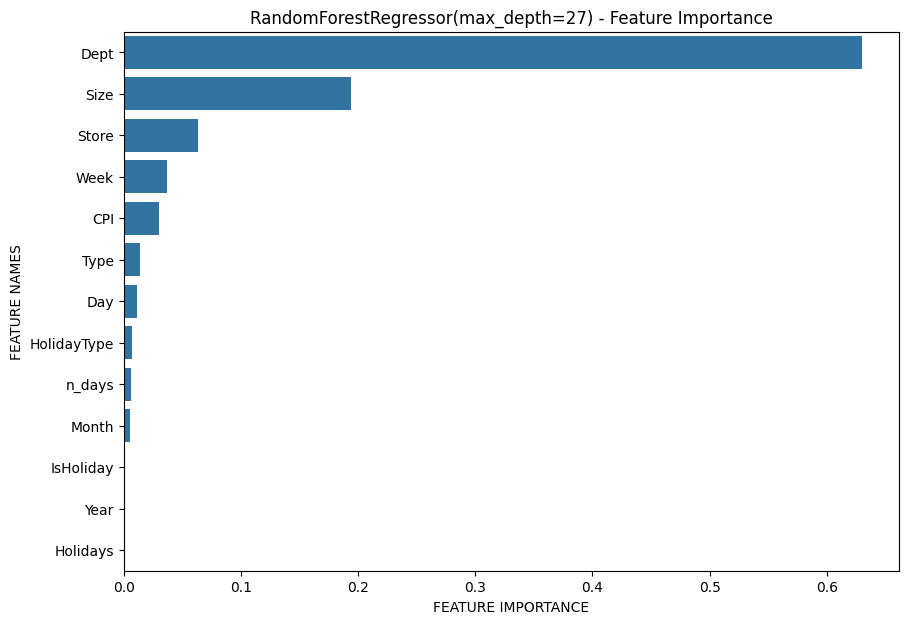

In [97]:
features_importance = RF.feature_importances_

plot_features_importance(
    features_importance,
    data.columns,
    RF
)

predection for week sales


In [98]:
def preprocess_data_for_prediction(store, department, date, is_holiday):
    # Create a DataFrame with the provided parameters
    input_data = pd.DataFrame({
        'Store': [store],
        'Dept': [department],
        'Date': [date],
        'IsHoliday': [is_holiday],
       
    })

    # Convert Date column to datetime type
    input_data['Date'] = pd.to_datetime(input_data['Date'])

    # Extract additional features
    input_data['Year'] = input_data['Date'].dt.year
    input_data['Month'] = input_data['Date'].dt.month
    input_data['Week'] = input_data['Date'].dt.isocalendar().week
    input_data['Day'] = input_data['Date'].dt.day
    input_data['n_days'] = (input_data['Date'].dt.date -
                            input_data['Date'].dt.date.min()).apply(lambda x: x.days)

    # Merge with features and stores dataframes
    input_data = pd.merge(input_data, features, on=[
                          'Store', 'Date', 'IsHoliday'], how='left')
    input_data = pd.merge(input_data, stores, on=['Store'], how='left')


    # Create Holiday Type
    create_Holiday_Type(input_data)

    # Determine Holidays
    dates = []
    for ptr in holidays.US(years=2010).items():
        dates.append(ptr[0])
    for ptr in holidays.US(years=2011).items():
        dates.append(ptr[0])
    for ptr in holidays.US(years=2012).items():
        dates.append(ptr[0])

    holidays_count = []
    for index, row in input_data.iterrows():
        dat = row['Date']
        dt = []
        for i in range(0, 5):
            dt.append(dat - datetime.timedelta(days=i))
        for i in range(1, 3):
            dt.append(dat + datetime.timedelta(days=i))
        count = 0
        for date in dates:
            if date in dt:
                count += 1
        holidays_count.append(count)

    # Add Holidays column to the DataFrame
    input_data['Holidays'] = np.array(holidays_count)


    # Select the required columns
    input_data = input_data[['Store', 'Size', 'Dept', 'Month', 'Type', 'Year',
                             'Week', 'Day', 'n_days', 'IsHoliday', 'Holidays', 'HolidayType', 'CPI']]

    # Convert 'Type' to categorical codes
    input_data['Type'] = input_data['Type'].astype('category')
    input_data['Type'] = input_data['Type'].cat.codes

    return input_data

In [99]:
def predict_weekly_sales(store, department, date, is_holiday,model):
    # Preprocess input data for prediction
    input_data = preprocess_data_for_prediction(
        store, department, date, is_holiday)

    # Normalize input data
    input_data_scaled = t.transform(input_data)

    # Make predictions using the trained Random Forest model
    predicted_sales = model.predict(input_data_scaled)

    return predicted_sales[0]

In [100]:
# Example usage:
store_number = 1
department_number = 1
date_value = '2012-11-02'
is_holiday_value = False


predicted_sales = predict_weekly_sales(
    store_number, department_number, date_value, is_holiday_value,RF)
print("Predicted Weekly Sales:", predicted_sales)

Predicted Weekly Sales: 1992.0631999999982


Training Dataset with GBDT Regressor

In [101]:
#max_depth = [20, 25]
#n_estimators = [6000, 7000, 8000]
#gbdt(n_estimators, max_depth)

In [102]:
gb = lgb.LGBMRegressor(n_estimators=8000, max_depth=25)
gb.fit(X, Y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 420212, number of used features: 12
[LightGBM] [Info] Start training from score 16033.114589


LGBMRegressor(max_depth=25, n_estimators=8000)

In [103]:
print(gb.score(data, train['Weekly_Sales']))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.9940881794712345


In [104]:
predict_Sales(gb, '2', data_test, test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [105]:
# Example usage:
store_number = 1
department_number = 1
date_value = '2012-11-02'
is_holiday_value = False


predicted_sales = predict_weekly_sales(
    store_number, department_number, date_value, is_holiday_value,gb)
print("Predicted Weekly Sales:", predicted_sales)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Predicted Weekly Sales: 23584.712656966778
